# import

In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import statistics

import joblib

# from sklearn.inspection import plot_partial_dependence

# function

In [2]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

In [3]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [4]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [5]:
def plot_cm(cm_val, save=False,which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [6]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [7]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [8]:
def false_predict_kitt(y_true, y_pred, split="test"):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    false_positive = []
    false_negative = []
    if split == "test":
        test_path =  "{}/test.csv".format(path)
        test_data = pd.read_csv(test_path)
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = test_data.loc[false_positive]
        false_negative_df = test_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    elif "split" in split:
        val_path =  "{}/{}/val/val.csv".format(path,split)
        val_data = pd.read_csv(val_path)
        false_indices = []
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = val_data.loc[false_positive]
        false_negative_df = val_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    x_col, y_col = "area_mean", "concavity_mean"
    # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
    plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
    plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
    plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
    plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
    # Add legend and labels
    plt.legend()
    plt.title(split)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Show the plot
    plt.show()
    
def train_param2(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SVC(C=100, gamma=0.001, kernel='rbf',probability=True)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SVM_progress3/model/param2/SVM_model_{}.pkl".format(split))
    
def kernal_svm_split5(split):
#     # import some data to play with
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     X = x_train[:, [0, 6]]  # we only take the first two features. We could
#                           # avoid this ugly slicing by using a two-dim dataset
#     y = y_train


#     # we create an instance of SVM and fit out data. We do not scale our
#     # data since we want to plot the support vectors
#     C = 100.0  # SVM regularization parameter
#     svc = svm.SVC(kernel='linear', C=C).fit(X, y)
#     rbf_svc = svm.SVC(kernel='rbf', gamma=0.1, C=C).fit(X, y)
#     poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
#     lin_svc = svm.LinearSVC(C=C).fit(X, y)

    model_path = "../SVM_progress3/model/param2/SVM_model_{}.pkl".format(split)
    loaded_model = joblib.load(model_path)
    
    x_train, y_train, x_test, y_test, x_val, y_val = setup(split)
    X = x_train[:, [0, 2]]
    y = y_train
    
    h = .02  # step size in the mesh
        
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['SVC with RBF kernel']


    for i, clf in enumerate(loaded_model): 
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlabel('area_mean')
        plt.ylabel('perimeter_mean')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()
    
def evaluate(param,split):
    model_path = "../SVM_progress3/model/param{}/SVM_model_{}.pkl".format(param,split)
    print(model_path)
    loaded_model = joblib.load(model_path)

    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, which="Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test,which="Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    
    # coef(param,split)
    
    print("################# false predict ##################")
    fp = false_predict(y_val, y_pred_val, split)
    print(fp)
    false_predict_kitt(y_val, y_pred_val, split=split)

    return cm_val,cm_test,auc1,auc2

In [9]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [10]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

In [11]:
def false_predict(y_true, y_pred, split):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3_new/"
    # test_path =  "{}/test.csv".format(path)
    # test_data = pd.read_csv(test_path)
    valid_path = "{}/{}/val/val.csv".format(path,split)
    val_data = pd.read_csv(valid_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(val_data.loc[false_indices])
    return false_indices

In [12]:
def coef(param,split):
    model_path = "../SVM/models/param{}/SVM_model_{}.pkl".format(param,split)
    loaded_model = joblib.load(model_path)
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    
    feature_coef = loaded_model.coef_

    # print the feature importance
    for i, coef in enumerate(feature_coef):
        coef_abs = np.abs(coef)
        df = pd.DataFrame({'Variable':x_train.columns,
              'Coef':coef_abs}).sort_values('Coef', ascending=False)
        
        print(df)

# find param

In [13]:
# def grid_search(x_train, y_train):
#     # Define parameter grid
#     param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#                 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
#     # Define SGD model
#     model = SVC()

#     # Define grid search object
#     grid_search = GridSearchCV(model, param_grid)

#     # Fit grid search object to the data
#     grid_search.fit(x_train, y_train)

#     # Print best parameter and score
#     # print('Best loss parameter:', grid_search.best_params_['loss'])
#     # print('Best penalty parameter:', grid_search.best_params_['penalty'])
#     # print('Best learning_rate parameter:', grid_search.best_params_['learning_rate'])
#     # print('Best eta0 parameter:', grid_search.best_params_['eta0'])
#     # print('Best max_iter parameter:', grid_search.best_params_['max_iter'])
#     # print('Best alpha parameter:', grid_search.best_params_['alpha'])
#     # print('Best score:', grid_search.best_score_)
#     print('Best param:', grid_search.best_params_)
#     print('Best score:', grid_search.best_score_)

In [14]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split1')
# grid_search(x_train, y_train)

In [15]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split2')
# grid_search(x_train, y_train)

In [16]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split3')
# grid_search(x_train, y_train)

In [17]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split4')
# grid_search(x_train, y_train)

In [18]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split5')
# grid_search(x_train, y_train)

# Set up all split

In [19]:
# def train_param1(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     model = SVC(C=10, gamma=0.1, kernel='rbf',probability=True)
#     model.fit(x_train, y_train)
#     joblib.dump(model, "../SVM_progress3/model/param1/SVM_model_{}.pkl".format(split))

In [20]:
# def train_param2(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     model = SVC(C=100, gamma=0.001, kernel='rbf',probability=True)
#     model.fit(x_train, y_train)
#     joblib.dump(model, "../SVM_progress3/model/param2/SVM_model_{}.pkl".format(split))

In [21]:
# def train_param3(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     model = SVC(C=0.1, gamma=1, kernel='linear',probability=True)
#     model.fit(x_train, y_train)
#     joblib.dump(model, "../SVM_progress3/model/param3/SVM_model_{}.pkl".format(split))

In [22]:
# def train_param4(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     model = SVC(C=100, gamma=0.1, kernel='rbf',probability=True)
#     model.fit(x_train, y_train)
#     joblib.dump(model, "../SVM_progress3/model/param4/SVM_model_{}.pkl".format(split))

In [23]:
# def train_param5(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     model = SVC(C=100, gamma=0.1, kernel='rbf',probability=True)
#     model.fit(x_train, y_train)
#     joblib.dump(model, "../SVM_progress3/model/param5/SVM_model_{}.pkl".format(split))

# Parameter1

## split1

In [24]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [25]:
# train_param1(split)

../SVM_progress3/model/param1/SVM_model_split1.pkl
############## validate set ################
Best Threshold=0.318366
FPR: 0.0702
TPR: 0.9412
Confusion Matrix
----------------
[[53  4]
 [ 2 32]] 

----------------
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%


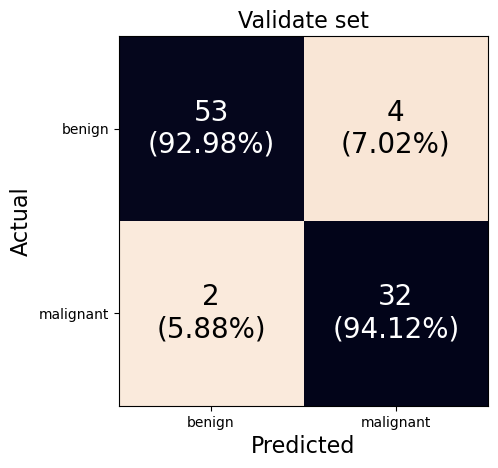

################# test set ##################
Best Threshold=0.163729
FPR: 0.0972
TPR: 0.9762
Confusion Matrix
----------------
[[65  7]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 90.28%
Accuracy: 92.98%
Precision: 85.42%
Sensitivity: 97.62%
Precision: 85.42%
F1: 91.11%


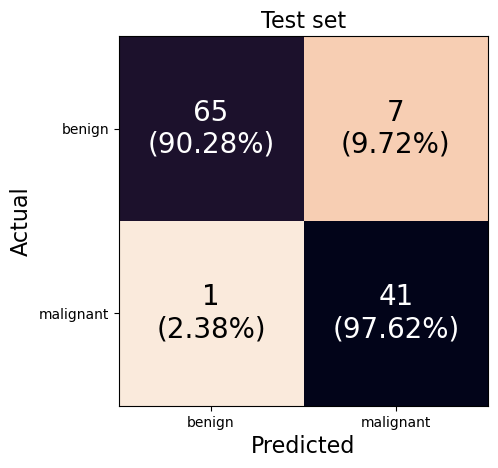

---------------------------------------
AUC validate: 97.32%
AUC test: 98.35%


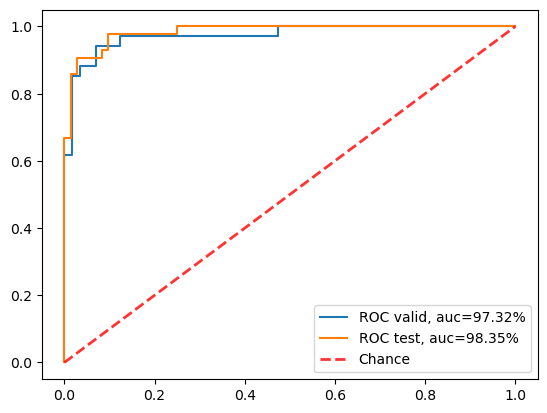

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
38   918192         B         13.17      594.2          0.12480   
44   868223         B         16.67      423.6          0.10510   
46  8710441         B         15.34      300.2          0.10720   
79   868202         M         22.47      506.3          0.09055   
81   862548         M         19.77      642.5          0.09752   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0.1844                 0.05268       2.060   
38         0.10100         0.1976                 0.06457       2.635   
44         0.03592         0.1339                 0.05945       2.508   
46         0.41080         0.2548                 0.09296       2.664   
79         0.04711         0.1585                 0.06065       1.380   
81         0.09388         0.1879        

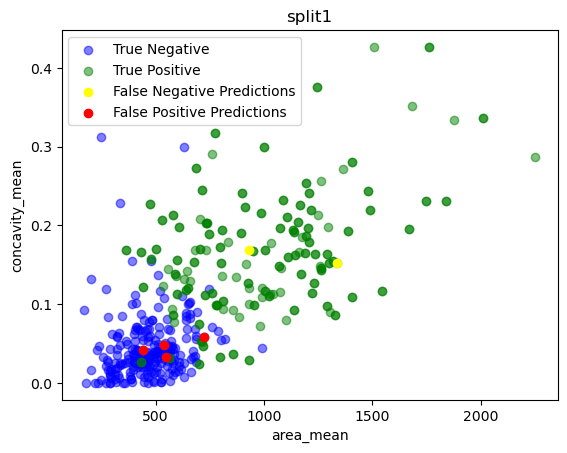

In [26]:
# hello world!
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## split2

In [27]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [28]:
# train_param1(split)

../SVM_progress3/model/param1/SVM_model_split2.pkl
############## validate set ################
Best Threshold=0.354520
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


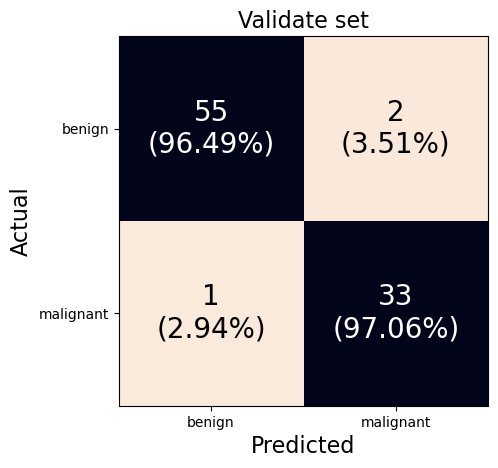

################# test set ##################
Best Threshold=0.357120
FPR: 0.0417
TPR: 0.9048
Confusion Matrix
----------------
[[69  3]
 [ 4 38]] 

----------------
split2
Sensitivity: 90.48%
Specificity: 95.83%
Accuracy: 93.86%
Precision: 92.68%
Sensitivity: 90.48%
Precision: 92.68%
F1: 91.57%


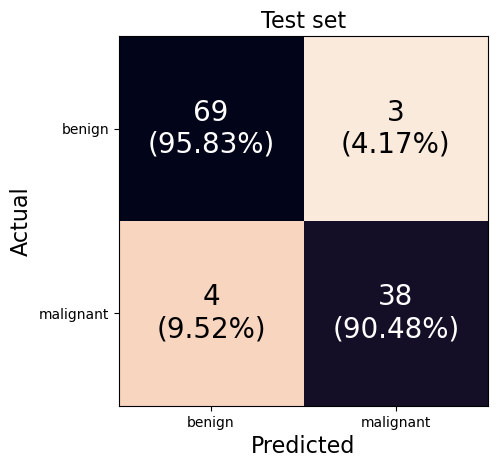

---------------------------------------
AUC validate: 98.14%
AUC test: 97.75%


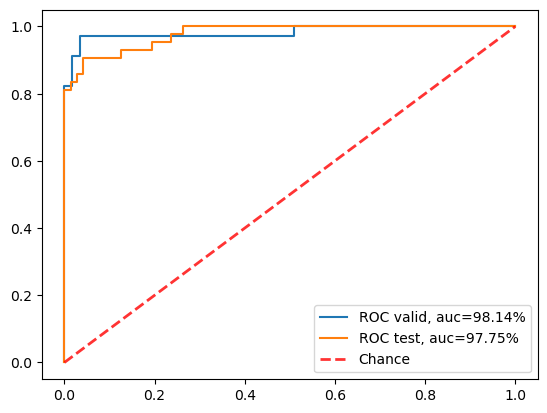

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
11   859471         B         17.33      250.5          0.10660   
12  9112366         B         29.29      415.1          0.09357   
57   855167         M         21.58      563.0          0.08162   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11          0.3130         0.2111                 0.08046      1.1940   
12          0.0716         0.1799                 0.06166      2.4260   
57          0.0311         0.1784                 0.05587      0.8265   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    17.67       0.009549       0.30380      0.04197              0.009559   
12    23.13       0.009861       0.04275      0.02475              0.002128   
57    20.53       0.003280       0.01390      0.01380              0.001286   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimensi

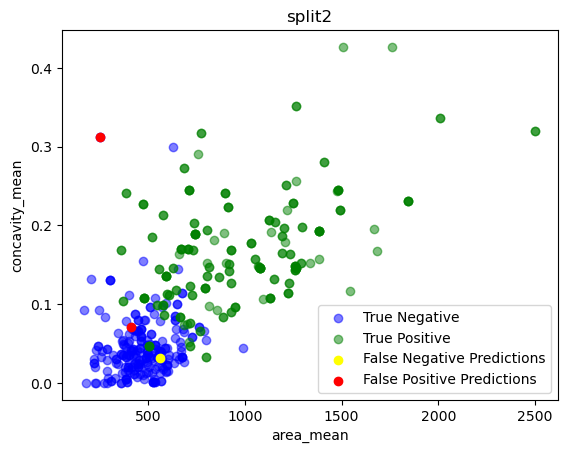

In [29]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## split3

In [30]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [31]:
# train_param1(split)

../SVM_progress3/model/param1/SVM_model_split3.pkl
############## validate set ################
Best Threshold=0.611258
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


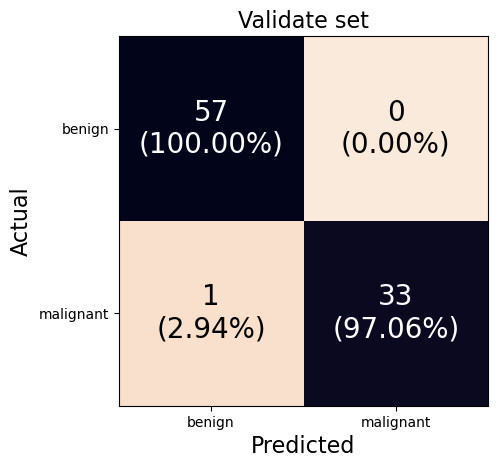

################# test set ##################
Best Threshold=0.400394
FPR: 0.0694
TPR: 0.9524
Confusion Matrix
----------------
[[67  5]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 93.06%
Accuracy: 93.86%
Precision: 88.89%
Sensitivity: 95.24%
Precision: 88.89%
F1: 91.95%


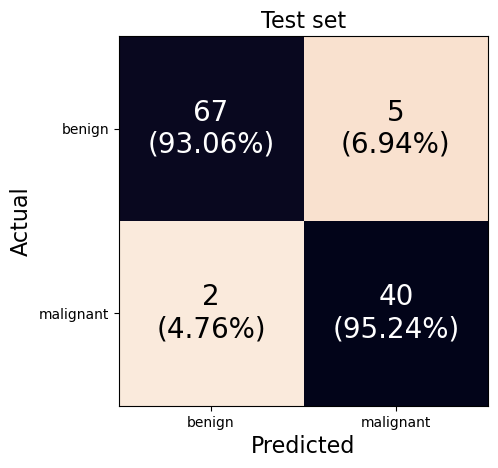

---------------------------------------
AUC validate: 98.92%
AUC test: 98.54%


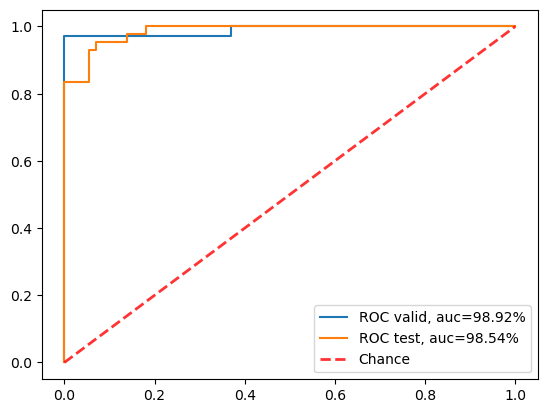

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
87  892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
87         0.02685         0.1619                 0.06287       2.105   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
87    49.11       0.005596       0.01272      0.01575              0.002758   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
87            0.1137           0.0612          0.1978                  0.06915  
[87]


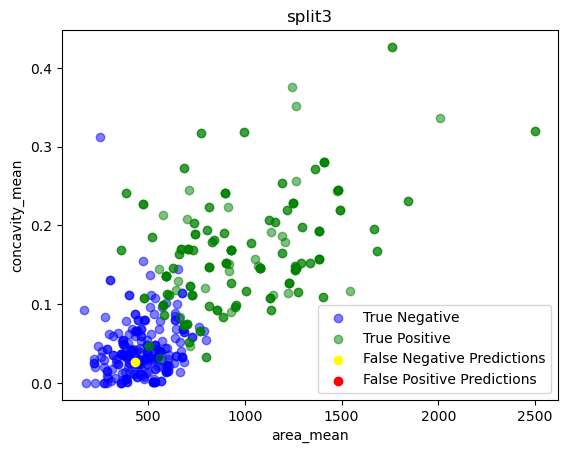

In [32]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## split4

In [33]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [34]:
# train_param1(split)

../SVM_progress3/model/param1/SVM_model_split4.pkl
############## validate set ################
Best Threshold=0.555415
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


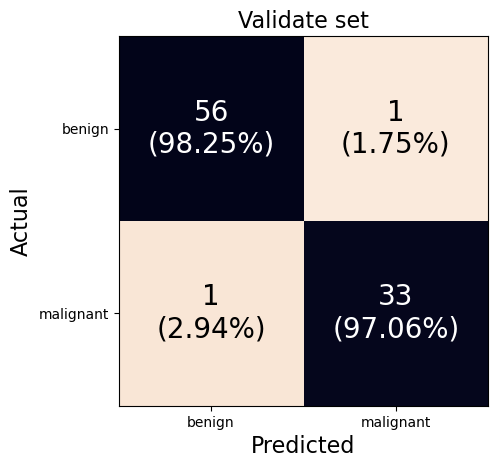

################# test set ##################
Best Threshold=0.515840
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


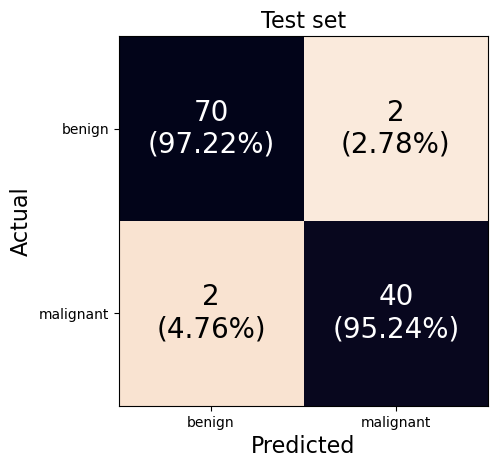

---------------------------------------
AUC validate: 99.02%
AUC test: 98.58%


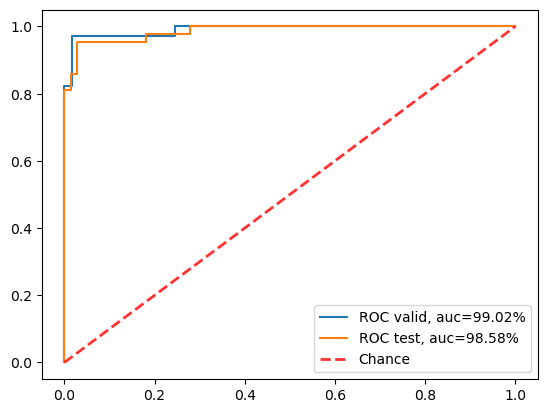

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.1872                 0.06341      1.0790   
70         0.07789         0.1662                 0.06566      0.6205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    23.11       0.007138       0.03829      0.02068              0.006111   
70    23.35       0.004717       0.01759      0.01220              0.003130   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1340           0.4040          0.3187                   0.1023  
70            0.1411           0.2779          0.2589                   0.1030  
[37, 70]


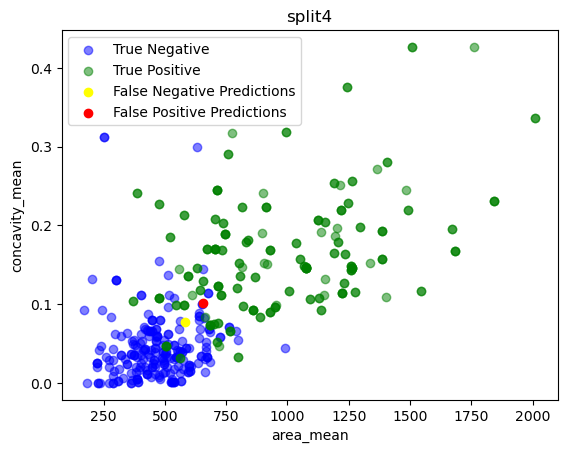

In [35]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## split5

In [36]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [37]:
# train_param1(split)

../SVM_progress3/model/param1/SVM_model_split5.pkl
############## validate set ################
Best Threshold=0.338298
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


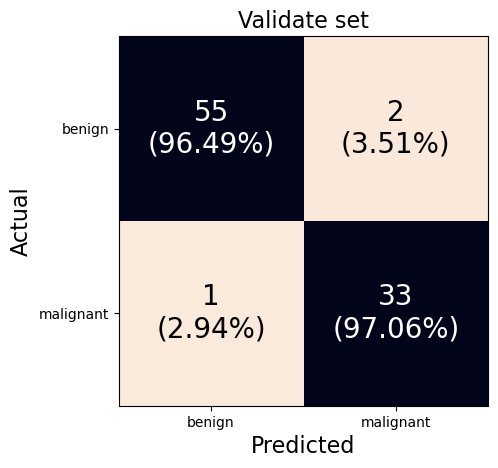

################# test set ##################
Best Threshold=0.308885
FPR: 0.0556
TPR: 0.9524
Confusion Matrix
----------------
[[68  4]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 94.44%
Accuracy: 94.74%
Precision: 90.91%
Sensitivity: 95.24%
Precision: 90.91%
F1: 93.02%


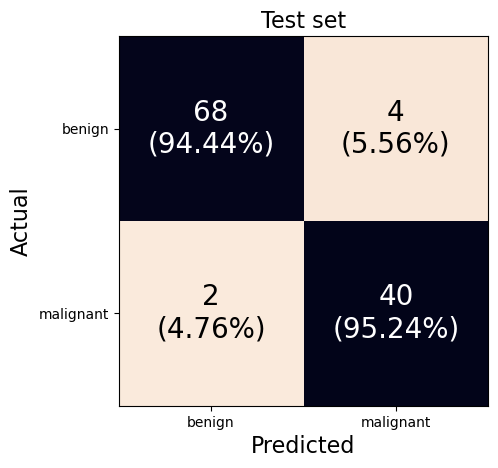

---------------------------------------
AUC validate: 98.97%
AUC test: 98.25%


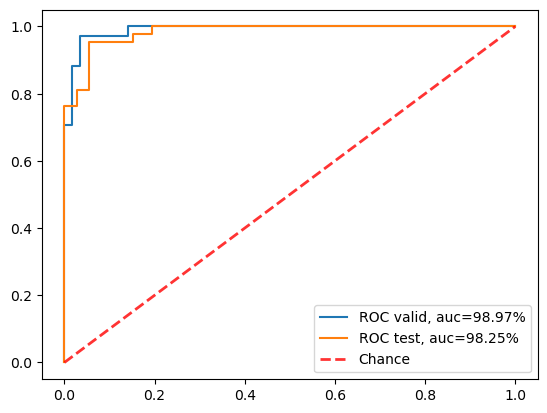

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
22     8915         B         19.10      687.3          0.08992   
43  9113455         B         20.74      536.9          0.08675   
87   905680         M         29.81      719.5          0.08320   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
22         0.05940         0.1879                 0.05852      0.9480   
43         0.10850         0.1562                 0.06020      0.7884   
87         0.04686         0.1852                 0.05294      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
22    24.87       0.005332       0.01536      0.01522              0.002815   
43    27.40       0.007295       0.04615      0.01561              0.003230   
87    45.38       0.006831       0.02489      0.03151              0.001750   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimensi

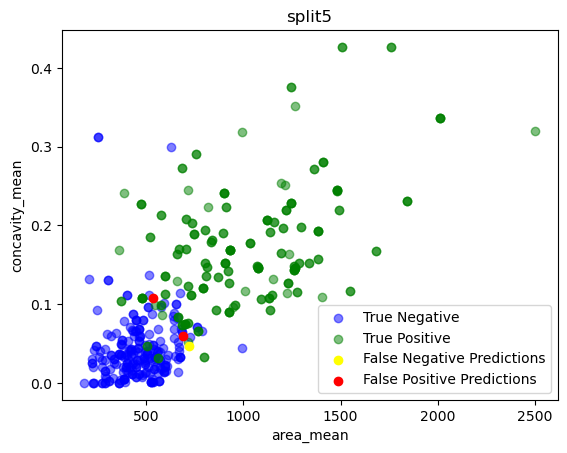

In [38]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

# Parameter2

## split1

In [39]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [40]:
# train_param2(split)

../SVM_progress3/model/param2/SVM_model_split1.pkl
############## validate set ################
Best Threshold=0.416384
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


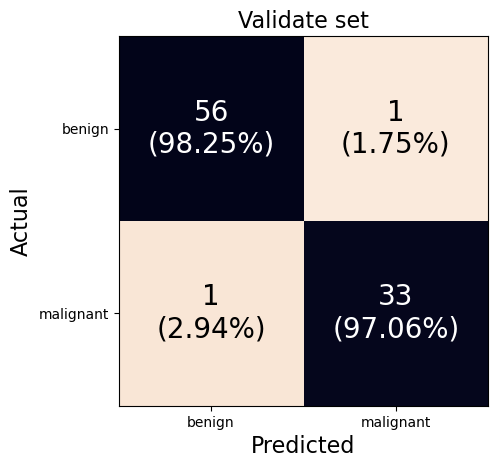

################# test set ##################
Best Threshold=0.455857
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


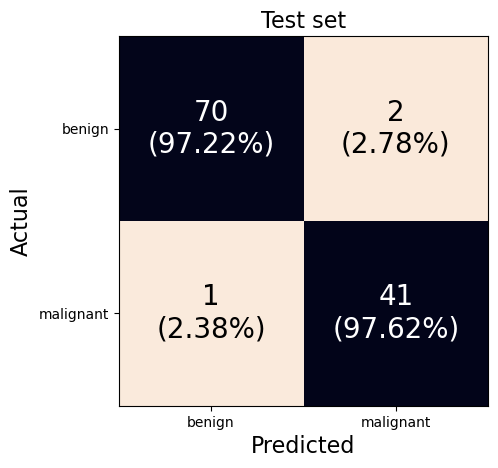

---------------------------------------
AUC validate: 99.69%
AUC test: 99.57%


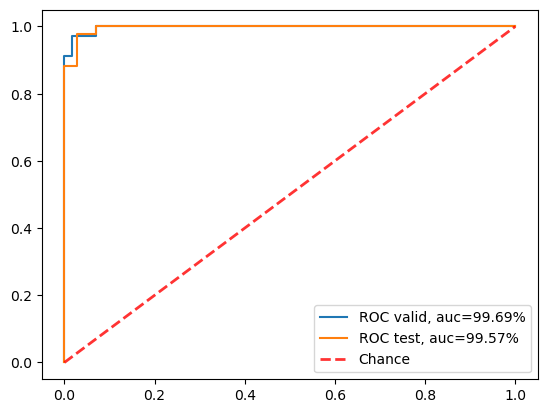

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47      506.3          0.09055   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0.1844                 0.05268        2.06   
79         0.04711         0.1585                 0.06065        1.38   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
36    46.61       0.003443       0.03056      0.01520              0.001519   
79    19.87       0.007499       0.02332      0.01647              0.002629   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
36           0.08774           0.1882          0.2527                  0.05972  
79           0.14190           0.2177          0.2829                  0.08067  
[36, 79]


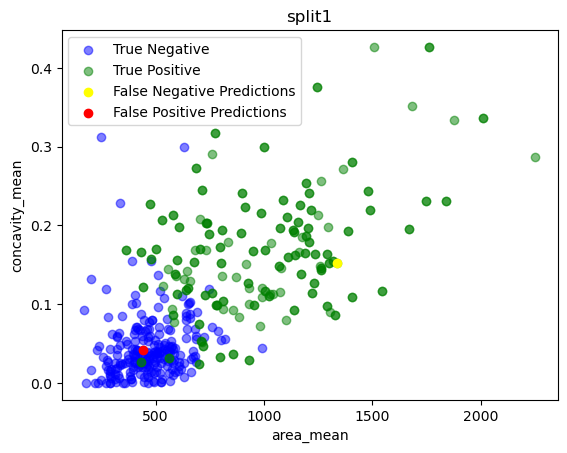

In [41]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## split2

In [42]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [43]:
# train_param2(split)

../SVM_progress3/model/param2/SVM_model_split2.pkl
############## validate set ################
Best Threshold=0.838663
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


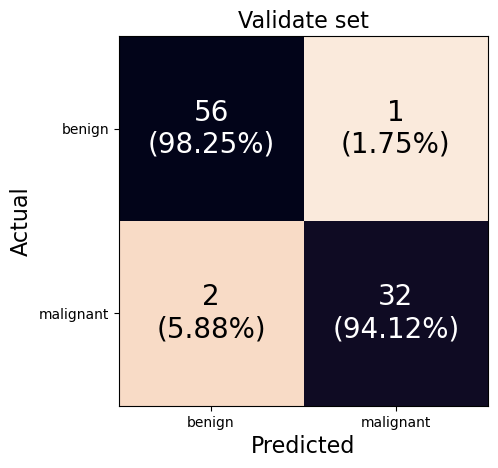

################# test set ##################
Best Threshold=0.625536
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


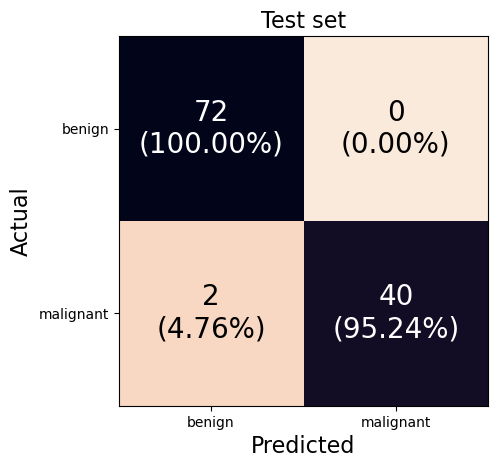

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


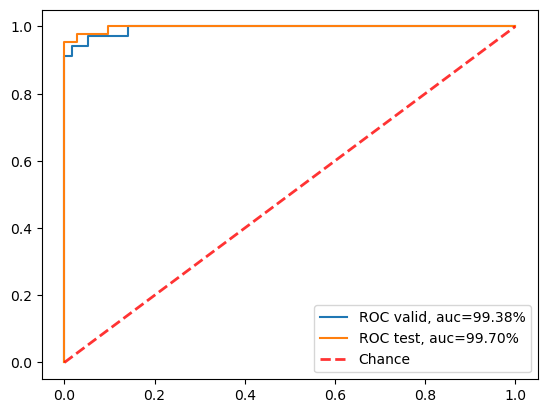

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
12   9112366         B         29.29      415.1          0.09357   
57    855167         M         21.58      563.0          0.08162   
87  91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
12         0.07160         0.1799                 0.06166      2.4260   
57         0.03110         0.1784                 0.05587      0.8265   
87         0.07486         0.1561                 0.05915      1.1980   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
12    23.13       0.009861       0.04275      0.02475              0.002128   
57    20.53       0.003280       0.01390      0.01380              0.001286   
87    38.49       0.004952       0.02967      0.01152              0.001718   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dim

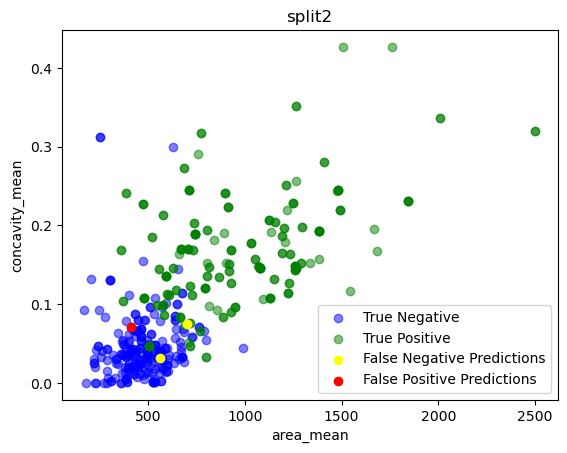

In [44]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## split3

In [45]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [46]:
# train_param2(split)

../SVM_progress3/model/param2/SVM_model_split3.pkl
############## validate set ################
Best Threshold=0.217653
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


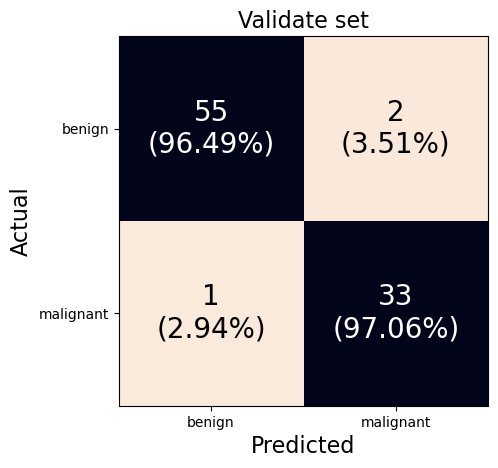

################# test set ##################
Best Threshold=0.594851
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


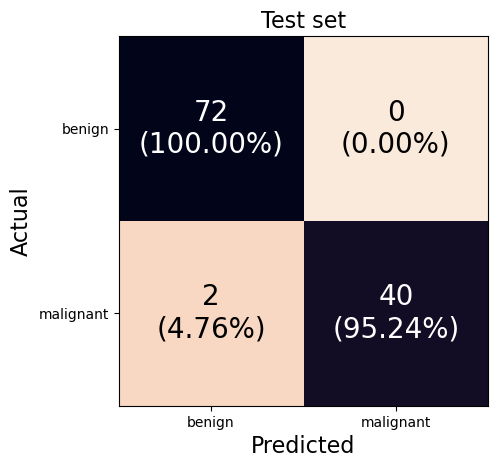

---------------------------------------
AUC validate: 98.56%
AUC test: 99.80%


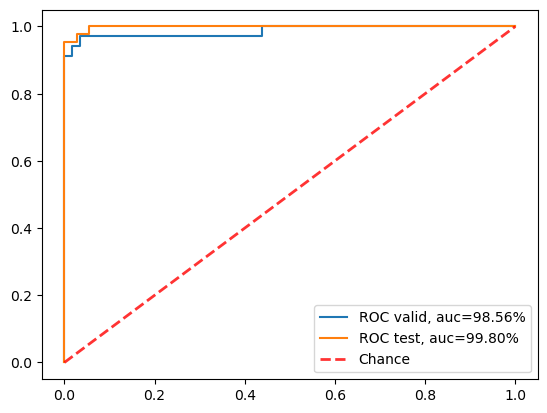

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
25  88147202         B         23.97      496.4          0.07903   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
1          0.04201         0.1723                 0.06317      0.6068   
25         0.05438         0.1514                 0.06019      1.0660   
87         0.02685         0.1619                 0.06287      2.1050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
1     16.07       0.004413       0.01509      0.01354              0.001787   
25    18.51       0.005169       0.03016      0.01365              0.003407   
87    49.11       0.005596       0.01272      0.01575              0.002758   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dim

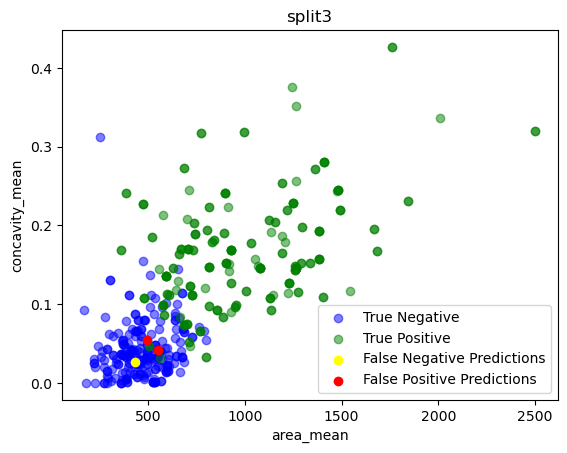

In [47]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## split4

In [48]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [49]:
# train_param2(split)

../SVM_progress3/model/param2/SVM_model_split4.pkl
############## validate set ################
Best Threshold=0.645649
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


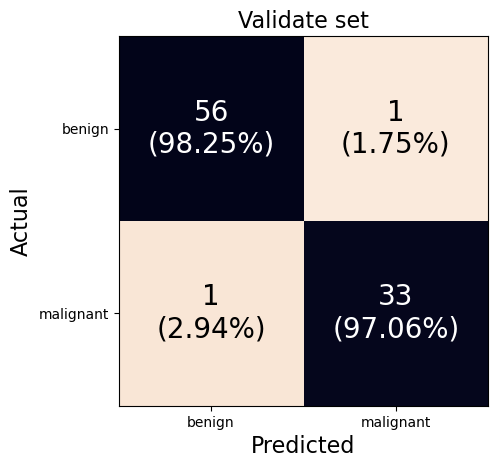

################# test set ##################
Best Threshold=0.580797
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


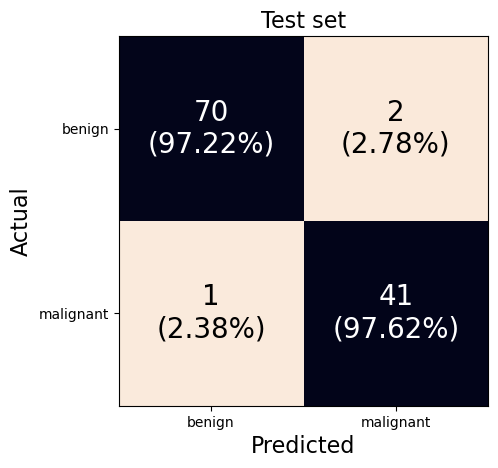

---------------------------------------
AUC validate: 99.69%
AUC test: 99.70%


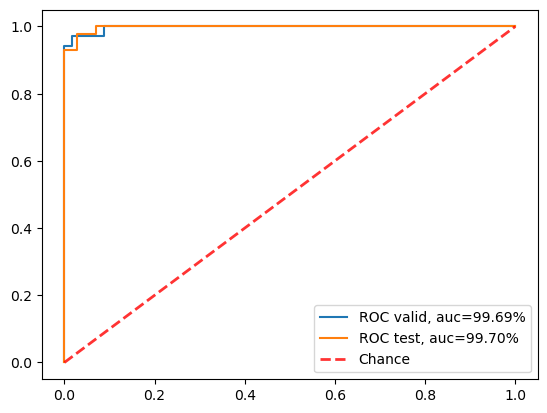

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.1872                 0.06341      1.0790   
70         0.07789         0.1662                 0.06566      0.6205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    23.11       0.007138       0.03829      0.02068              0.006111   
70    23.35       0.004717       0.01759      0.01220              0.003130   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1340           0.4040          0.3187                   0.1023  
70            0.1411           0.2779          0.2589                   0.1030  
[37, 70]


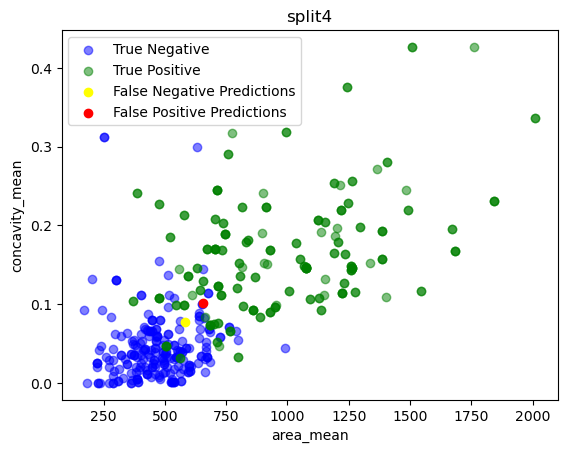

In [50]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## split5

In [51]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [52]:
# train_param2(split)

../SVM_progress3/model/param2/SVM_model_split5.pkl
############## validate set ################
Best Threshold=0.704776
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


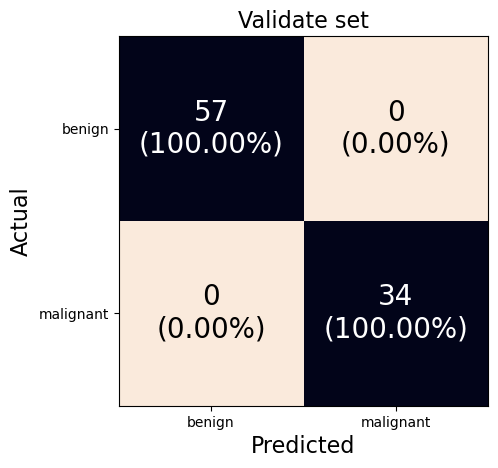

################# test set ##################
Best Threshold=0.663666
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


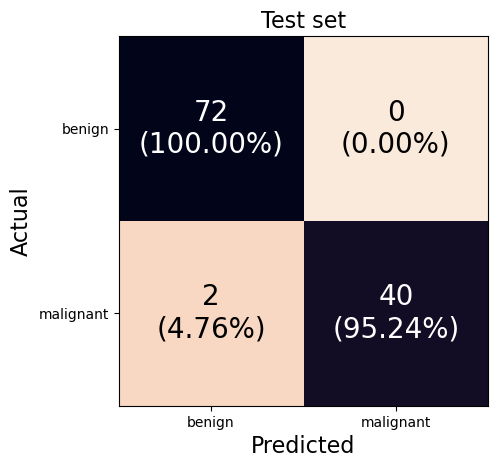

---------------------------------------
AUC validate: 100.00%
AUC test: 99.70%


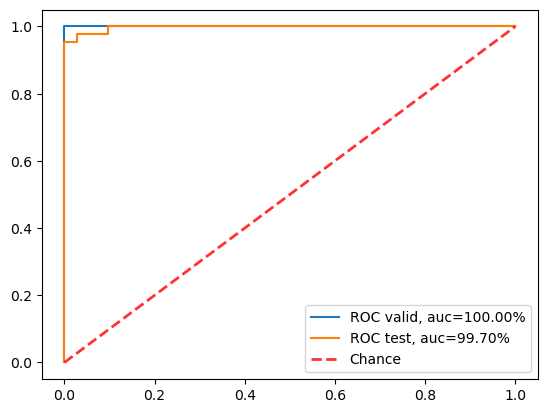

################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Index: []
[]


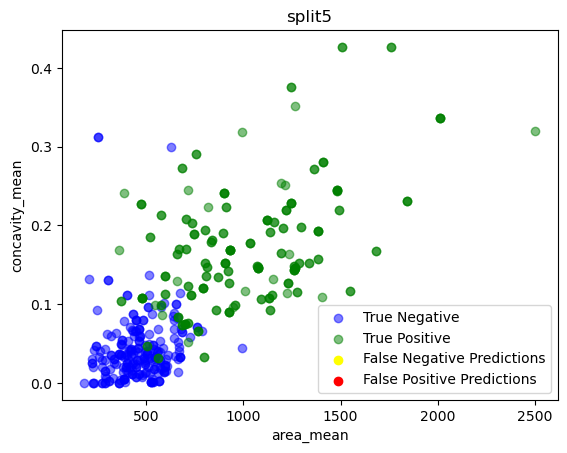

In [53]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

# Parameter 3

## split1

In [54]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [55]:
# train_param3(split)

../SVM_progress3/model/param3/SVM_model_split1.pkl
############## validate set ################
Best Threshold=0.422355
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


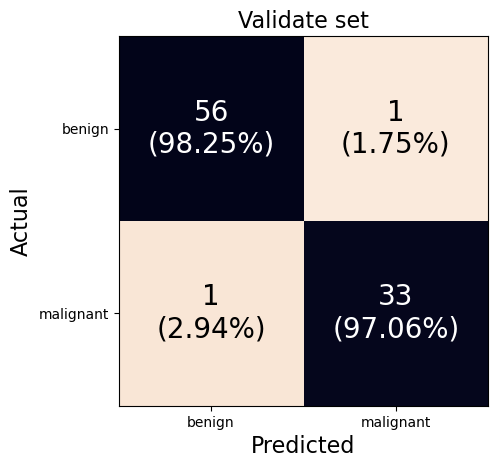

################# test set ##################
Best Threshold=0.500000
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


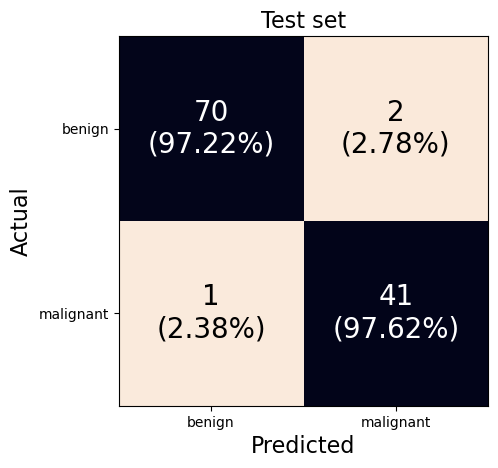

---------------------------------------
AUC validate: 99.59%
AUC test: 99.54%


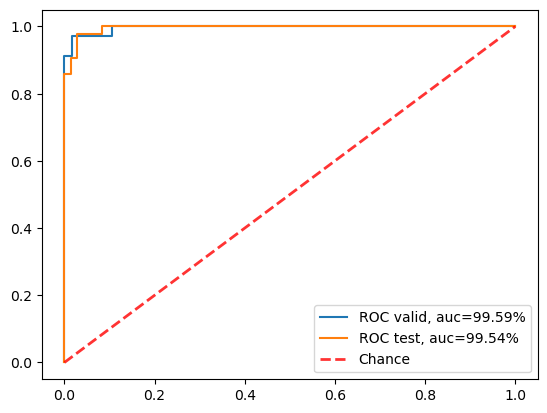

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47      506.3          0.09055   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0.1844                 0.05268        2.06   
79         0.04711         0.1585                 0.06065        1.38   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
36    46.61       0.003443       0.03056      0.01520              0.001519   
79    19.87       0.007499       0.02332      0.01647              0.002629   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
36           0.08774           0.1882          0.2527                  0.05972  
79           0.14190           0.2177          0.2829                  0.08067  
[36, 79]


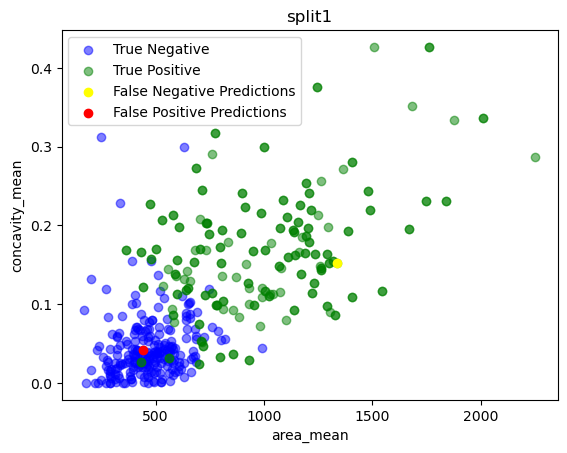

In [56]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## split2

In [57]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [58]:
# train_param3(split)

../SVM_progress3/model/param3/SVM_model_split2.pkl
############## validate set ################
Best Threshold=0.947412
FPR: 0.0000
TPR: 0.9118
Confusion Matrix
----------------
[[57  0]
 [ 3 31]] 

----------------
split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


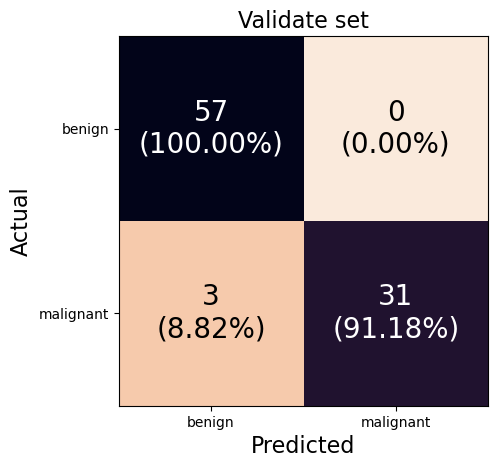

################# test set ##################
Best Threshold=0.715025
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


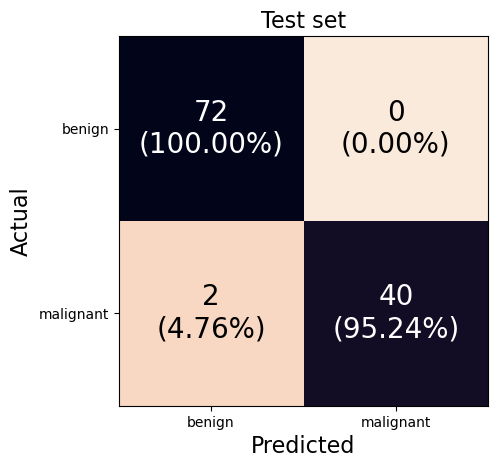

---------------------------------------
AUC validate: 99.28%
AUC test: 99.70%


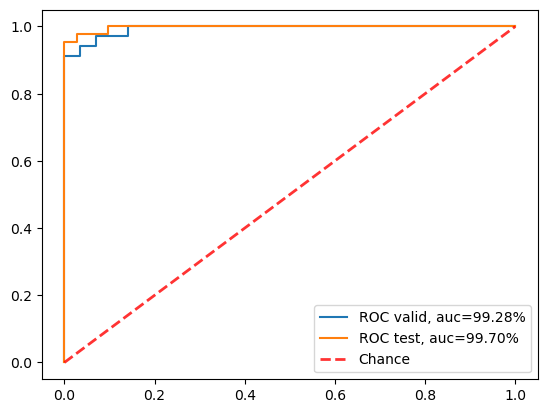

################# false predict ##################
           id diagnosis  texture_mean  area_mean  smoothness_mean  \
57     855167         M         21.58      563.0          0.08162   
79  881094802         M         25.56      948.0          0.10060   
87   91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.03110         0.1784                 0.05587      0.8265   
79         0.16820         0.1308                 0.05866      1.6670   
87         0.07486         0.1561                 0.05915      1.1980   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    20.53       0.003280       0.01390      0.01380              0.001286   
79    58.53       0.031130       0.14380      0.02175              0.012560   
87    38.49       0.004952       0.02967      0.01152              0.001718   

    smoothness_worst  concavity_worst  symmetry_worst  fractal

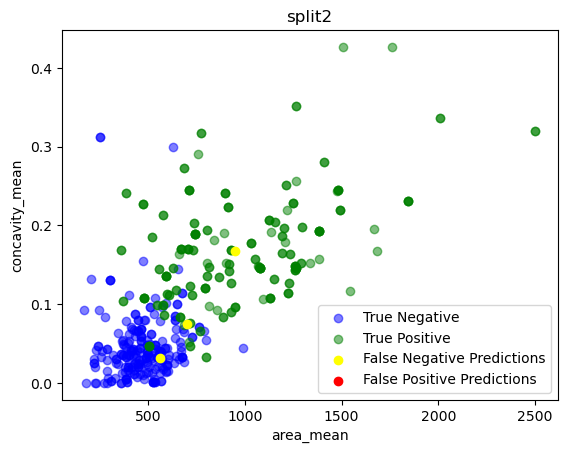

In [59]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## split3

In [60]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [61]:
# train_param3(split)

../SVM_progress3/model/param3/SVM_model_split3.pkl
############## validate set ################
Best Threshold=0.405516
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


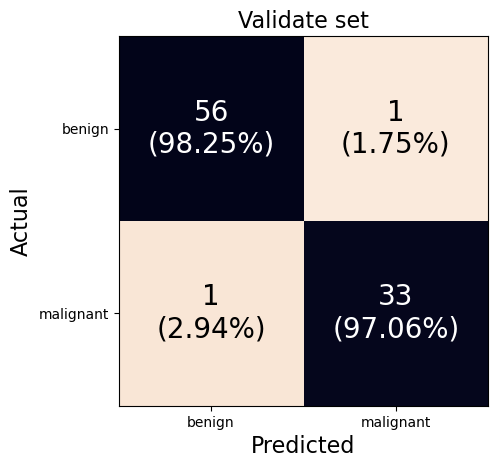

################# test set ##################
Best Threshold=0.648353
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


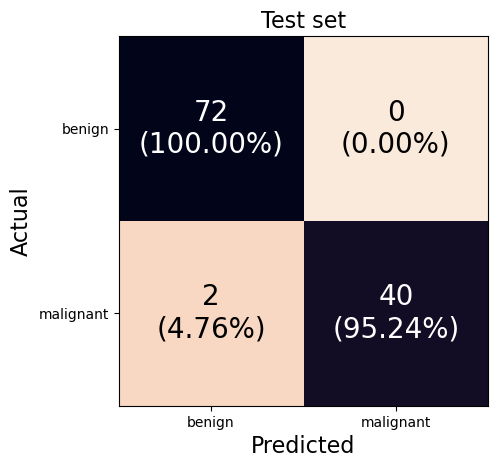

---------------------------------------
AUC validate: 98.40%
AUC test: 99.67%


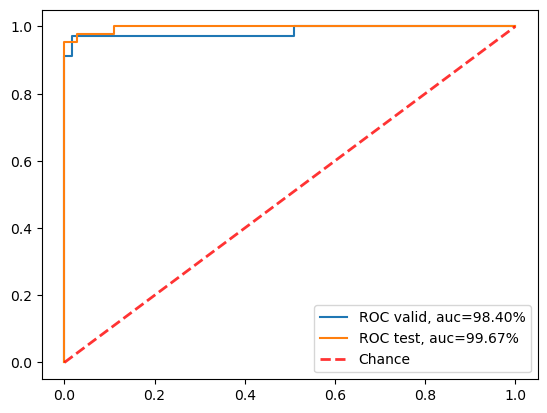

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
1          0.04201         0.1723                 0.06317      0.6068   
87         0.02685         0.1619                 0.06287      2.1050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
1     16.07       0.004413       0.01509      0.01354              0.001787   
87    49.11       0.005596       0.01272      0.01575              0.002758   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
1             0.1624           0.2654          0.3518                  0.08665  
87            0.1137           0.0612          0.1978                  0.06915  
[1, 87]


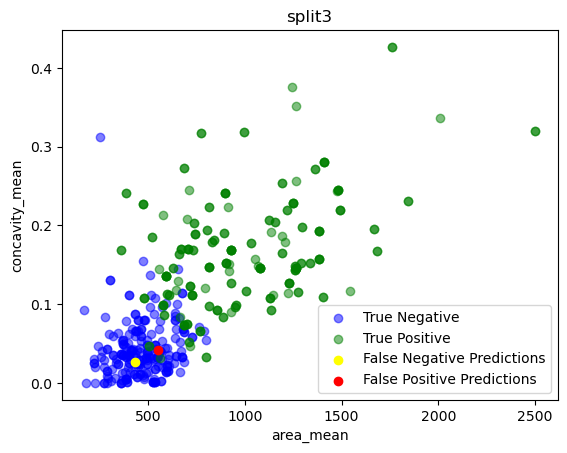

In [62]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## split4

In [63]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [64]:
# train_param3(split)

../SVM_progress3/model/param3/SVM_model_split4.pkl
############## validate set ################
Best Threshold=0.704809
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


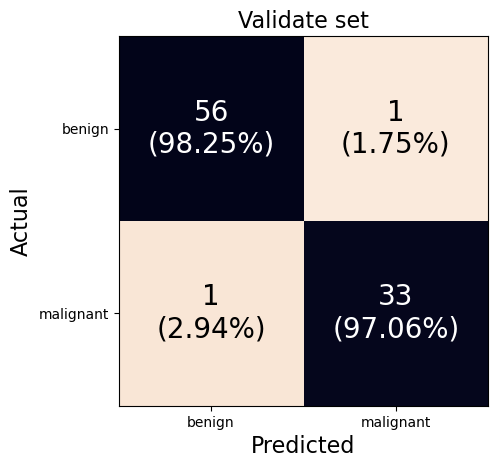

################# test set ##################
Best Threshold=0.551028
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


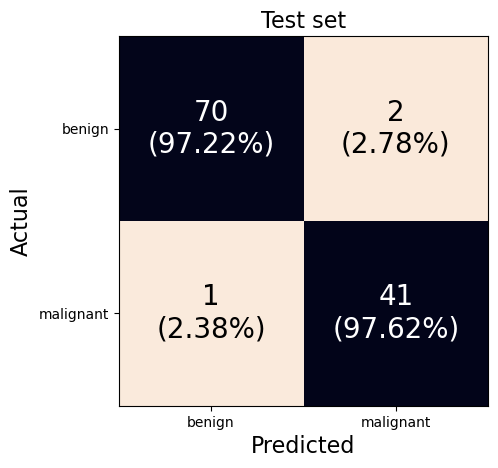

---------------------------------------
AUC validate: 99.43%
AUC test: 99.57%


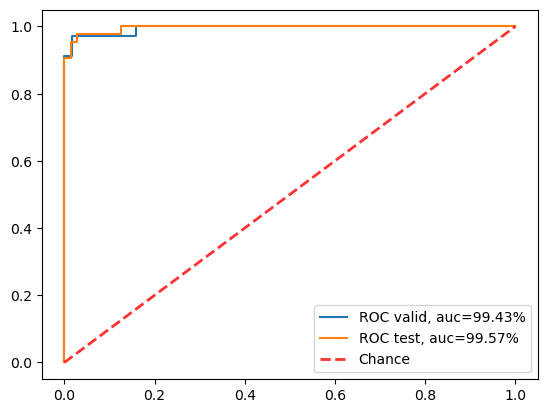

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.1872                 0.06341      1.0790   
70         0.07789         0.1662                 0.06566      0.6205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    23.11       0.007138       0.03829      0.02068              0.006111   
70    23.35       0.004717       0.01759      0.01220              0.003130   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1340           0.4040          0.3187                   0.1023  
70            0.1411           0.2779          0.2589                   0.1030  
[37, 70]


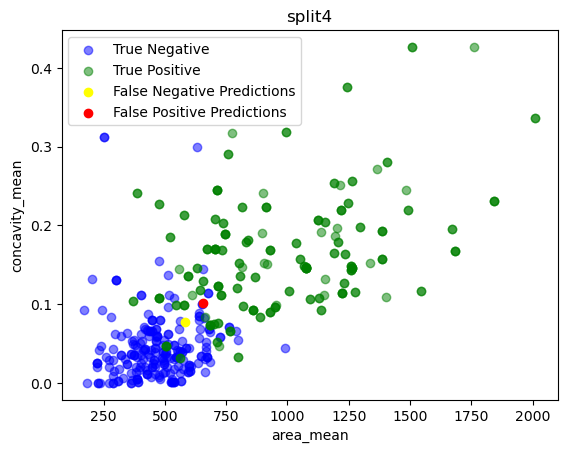

In [65]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## split5

In [66]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [67]:
# train_param3(split)

../SVM_progress3/model/param3/SVM_model_split5.pkl
############## validate set ################
Best Threshold=0.669253
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


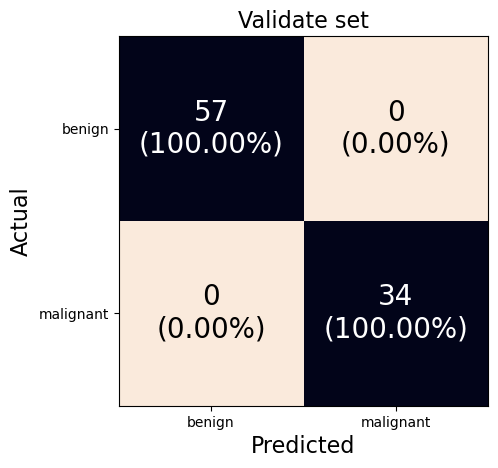

################# test set ##################
Best Threshold=0.546192
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


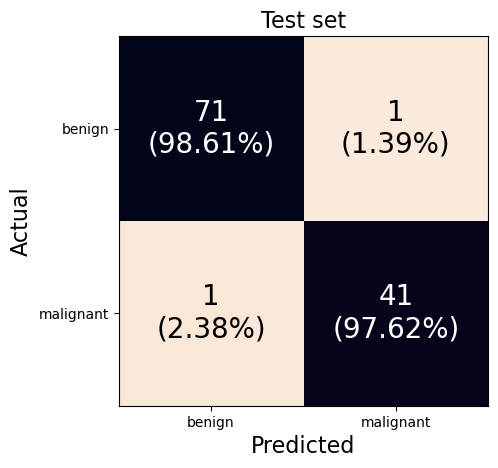

---------------------------------------
AUC validate: 100.00%
AUC test: 99.74%


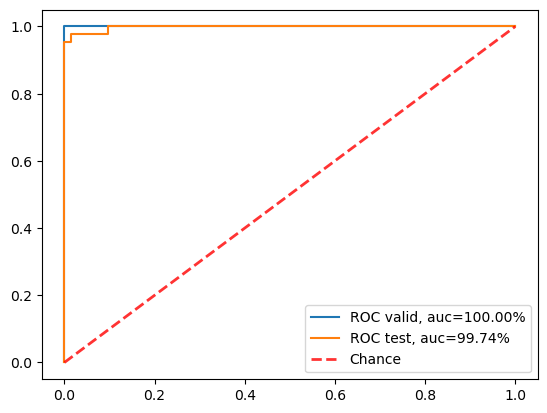

################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Index: []
[]


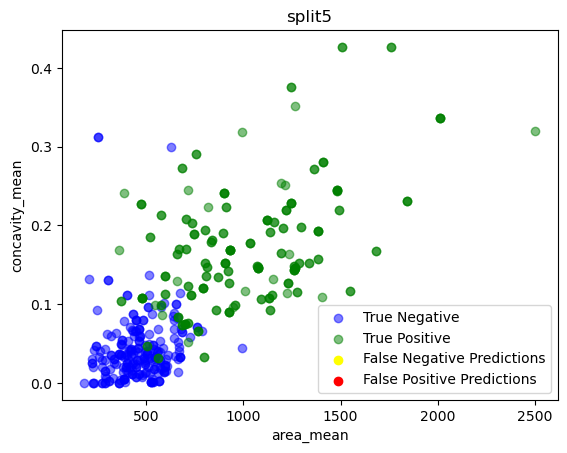

In [68]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

# Parameter 4

## split1

In [69]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [70]:
# train_param4(split)

../SVM_progress3/model/param4/SVM_model_split1.pkl
############## validate set ################
Best Threshold=0.204300
FPR: 0.0702
TPR: 0.9412
Confusion Matrix
----------------
[[53  4]
 [ 2 32]] 

----------------
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%


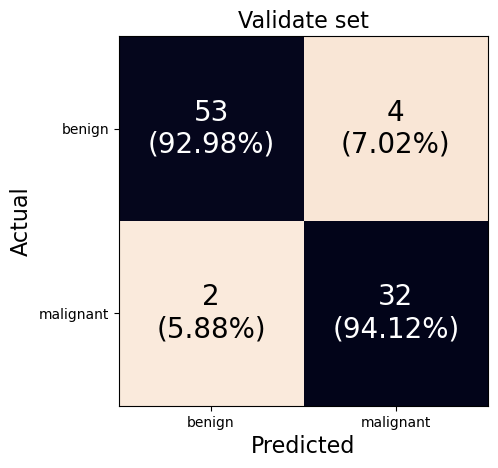

################# test set ##################
Best Threshold=0.348380
FPR: 0.0278
TPR: 0.9048
Confusion Matrix
----------------
[[70  2]
 [ 4 38]] 

----------------
split1
Sensitivity: 90.48%
Specificity: 97.22%
Accuracy: 94.74%
Precision: 95.00%
Sensitivity: 90.48%
Precision: 95.00%
F1: 92.68%


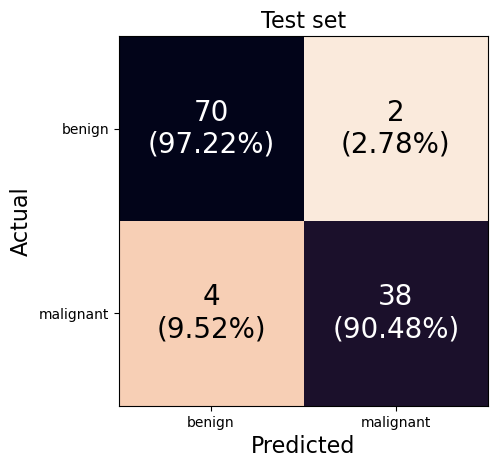

---------------------------------------
AUC validate: 97.16%
AUC test: 98.31%


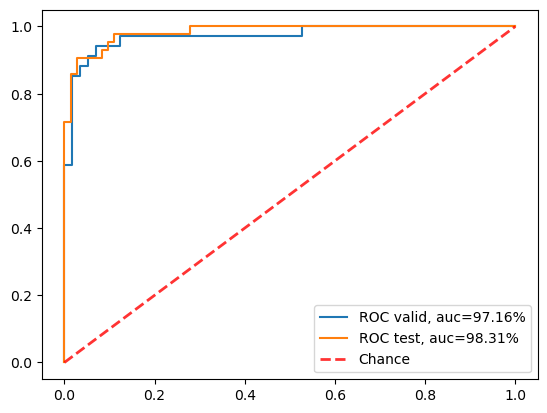

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
38   918192         B         13.17      594.2          0.12480   
44   868223         B         16.67      423.6          0.10510   
46  8710441         B         15.34      300.2          0.10720   
79   868202         M         22.47      506.3          0.09055   
81   862548         M         19.77      642.5          0.09752   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0.1844                 0.05268       2.060   
38         0.10100         0.1976                 0.06457       2.635   
44         0.03592         0.1339                 0.05945       2.508   
46         0.41080         0.2548                 0.09296       2.664   
79         0.04711         0.1585                 0.06065       1.380   
81         0.09388         0.1879        

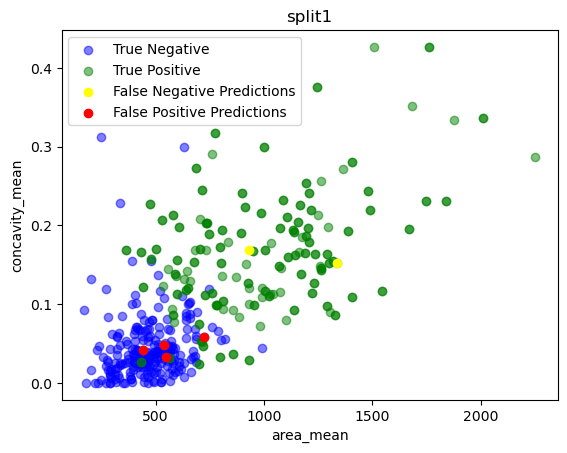

In [71]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## split2

In [72]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [73]:
# train_param4(split)

../SVM_progress3/model/param4/SVM_model_split2.pkl
############## validate set ################
Best Threshold=0.418671
FPR: 0.0526
TPR: 0.9412
Confusion Matrix
----------------
[[54  3]
 [ 2 32]] 

----------------
split2
Sensitivity: 94.12%
Specificity: 94.74%
Accuracy: 94.51%
Precision: 91.43%
Sensitivity: 94.12%
Precision: 91.43%
F1: 92.75%


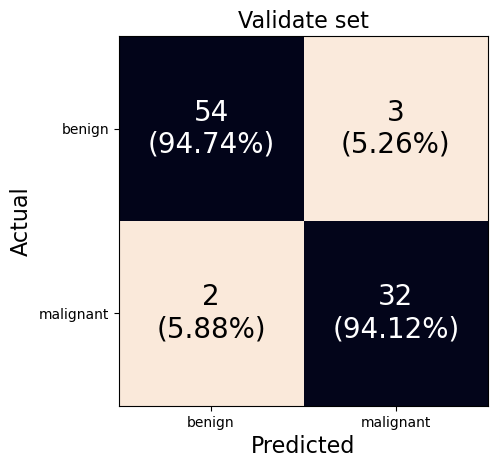

################# test set ##################
Best Threshold=0.364050
FPR: 0.0833
TPR: 0.9048
Confusion Matrix
----------------
[[66  6]
 [ 4 38]] 

----------------
split2
Sensitivity: 90.48%
Specificity: 91.67%
Accuracy: 91.23%
Precision: 86.36%
Sensitivity: 90.48%
Precision: 86.36%
F1: 88.37%


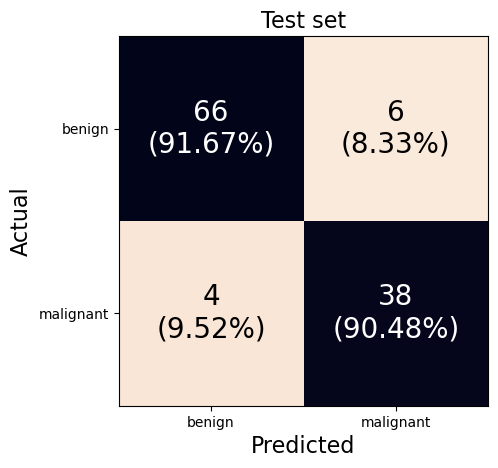

---------------------------------------
AUC validate: 97.27%
AUC test: 97.09%


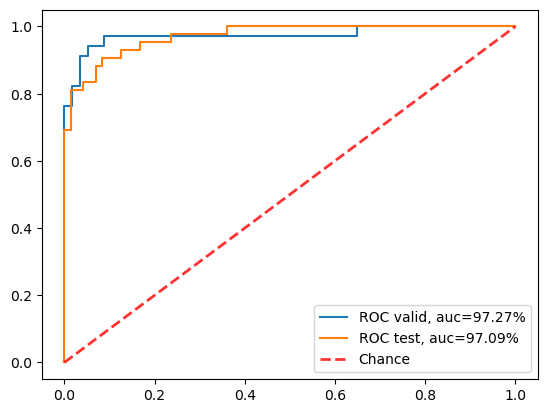

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
11    859471         B         17.33      250.5          0.10660   
12   9112366         B         29.29      415.1          0.09357   
49  88249602         B         21.25      603.4          0.09070   
57    855167         M         21.58      563.0          0.08162   
87  91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.31300         0.2111                 0.08046      1.1940   
12         0.07160         0.1799                 0.06166      2.4260   
49         0.01462         0.1517                 0.05835      1.5030   
57         0.03110         0.1784                 0.05587      0.8265   
87         0.07486         0.1561                 0.05915      1.1980   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    17.67       0.00

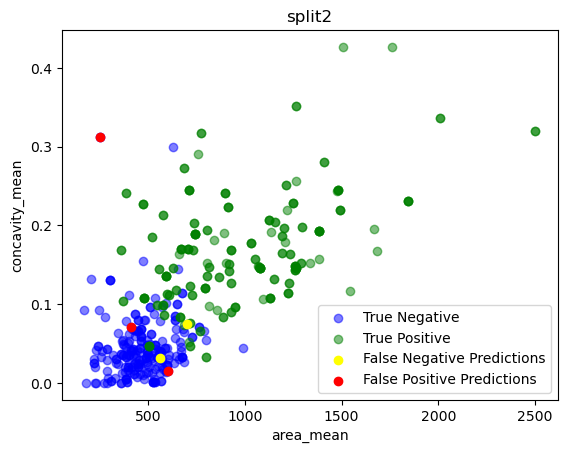

In [74]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## split3

In [75]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [76]:
# train_param4(split)

../SVM_progress3/model/param4/SVM_model_split3.pkl
############## validate set ################
Best Threshold=0.632788
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


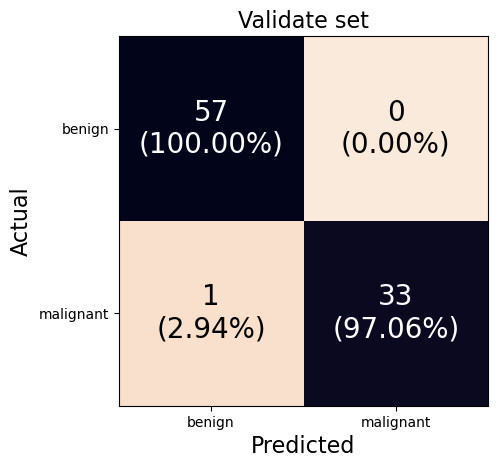

################# test set ##################
Best Threshold=0.127275
FPR: 0.1389
TPR: 1.0000
Confusion Matrix
----------------
[[62 10]
 [ 0 42]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 86.11%
Accuracy: 91.23%
Precision: 80.77%
Sensitivity: 100.00%
Precision: 80.77%
F1: 89.36%


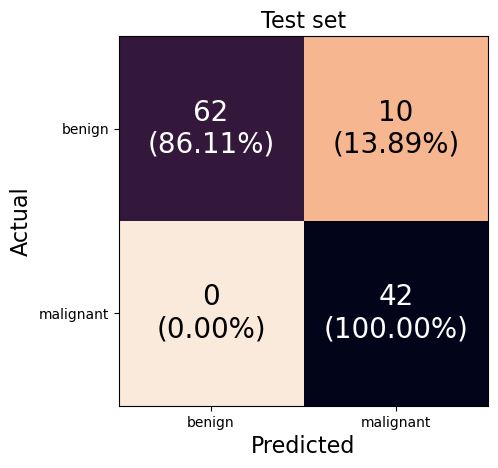

---------------------------------------
AUC validate: 98.45%
AUC test: 98.21%


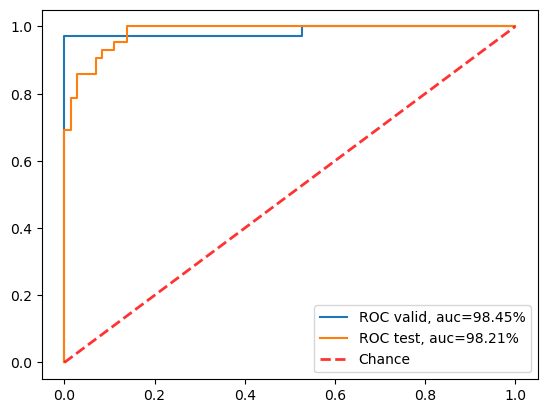

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
87  892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
87         0.02685         0.1619                 0.06287       2.105   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
87    49.11       0.005596       0.01272      0.01575              0.002758   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
87            0.1137           0.0612          0.1978                  0.06915  
[87]


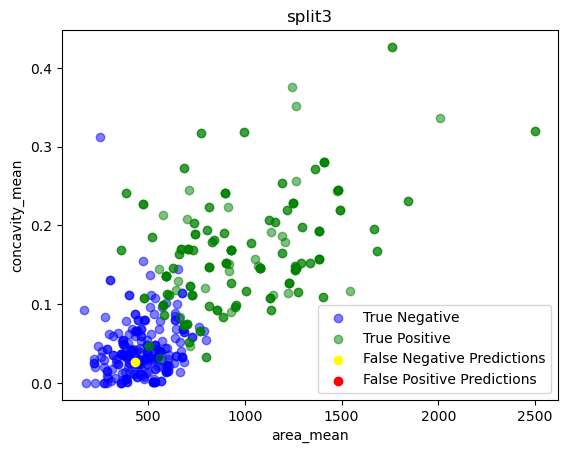

In [77]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## split4

In [78]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [79]:
# train_param4(split)

../SVM_progress3/model/param4/SVM_model_split4.pkl
############## validate set ################
Best Threshold=0.612130
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


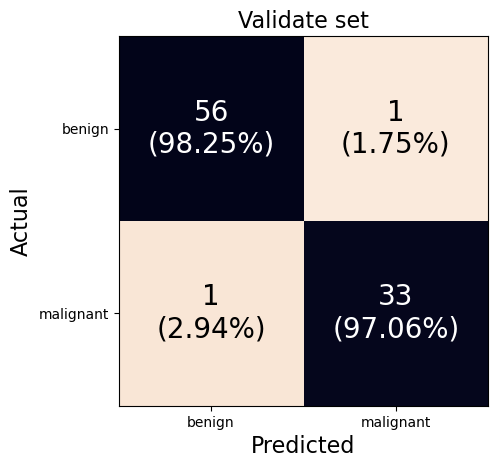

################# test set ##################
Best Threshold=0.490823
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


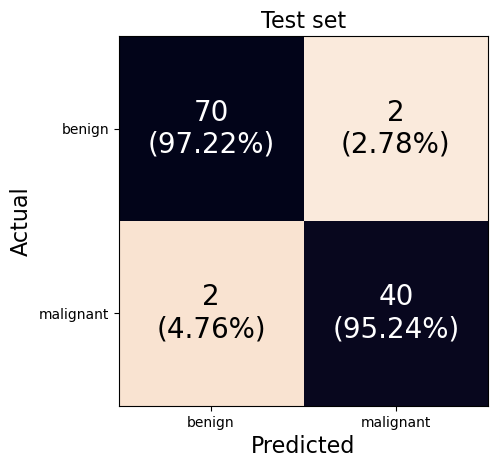

---------------------------------------
AUC validate: 98.66%
AUC test: 98.12%


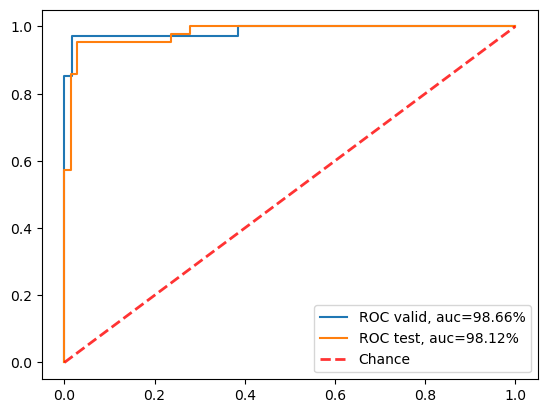

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.1872                 0.06341      1.0790   
70         0.07789         0.1662                 0.06566      0.6205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    23.11       0.007138       0.03829      0.02068              0.006111   
70    23.35       0.004717       0.01759      0.01220              0.003130   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1340           0.4040          0.3187                   0.1023  
70            0.1411           0.2779          0.2589                   0.1030  
[37, 70]


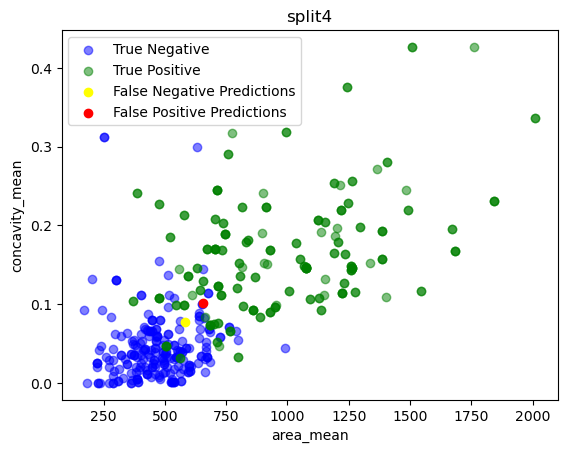

In [80]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## split5

In [81]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [82]:
# train_param4(split)

../SVM_progress3/model/param4/SVM_model_split5.pkl
############## validate set ################
Best Threshold=0.164490
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


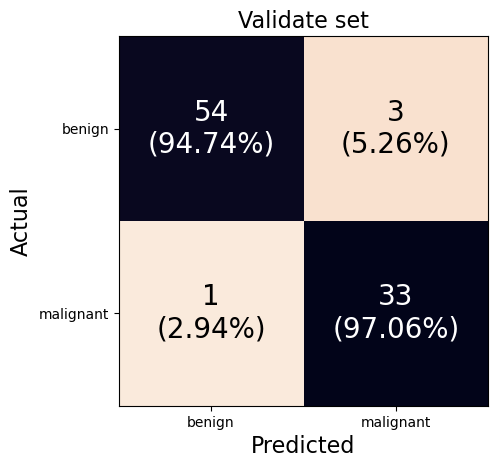

################# test set ##################
Best Threshold=0.252260
FPR: 0.0833
TPR: 0.9524
Confusion Matrix
----------------
[[66  6]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 91.67%
Accuracy: 92.98%
Precision: 86.96%
Sensitivity: 95.24%
Precision: 86.96%
F1: 90.91%


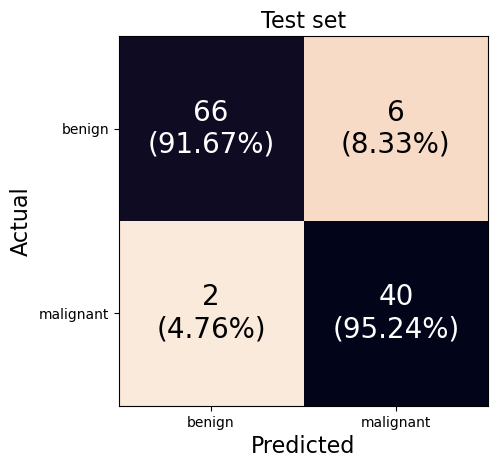

---------------------------------------
AUC validate: 98.25%
AUC test: 97.65%


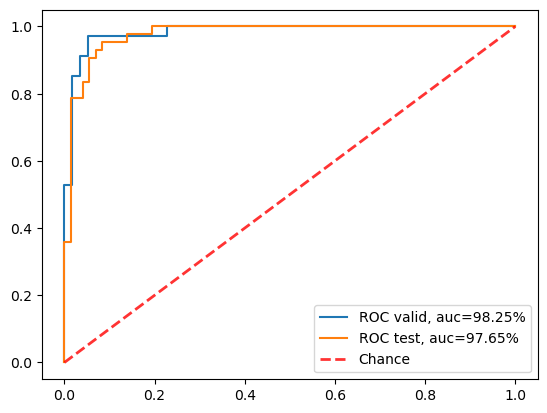

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
20   905502         B         17.57      399.8          0.08858   
22     8915         B         19.10      687.3          0.08992   
43  9113455         B         20.74      536.9          0.08675   
87   905680         M         29.81      719.5          0.08320   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.02783         0.1601                 0.05913      1.5550   
22         0.05940         0.1879                 0.05852      0.9480   
43         0.10850         0.1562                 0.06020      0.7884   
87         0.04686         0.1852                 0.05294      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
20    13.66       0.005391       0.01163      0.01341              0.001659   
22    24.87       0.005332       0.01536      0.01522              0.002815   
43    27.4

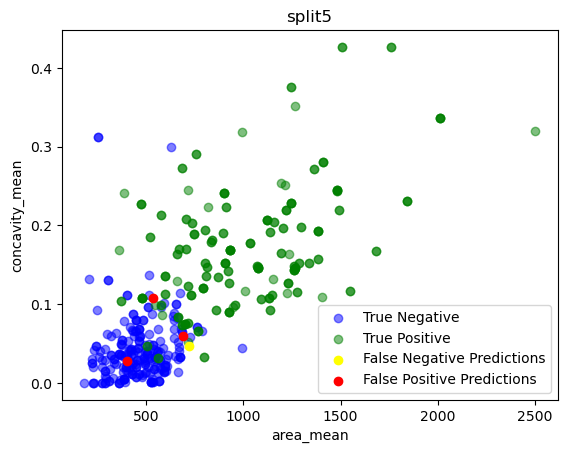

In [83]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

# Parameter 5

## split1

In [84]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [85]:
# train_param5(split)

../SVM_progress3/model/param5/SVM_model_split1.pkl
############## validate set ################
Best Threshold=0.261571
FPR: 0.0702
TPR: 0.9412
Confusion Matrix
----------------
[[53  4]
 [ 2 32]] 

----------------
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%


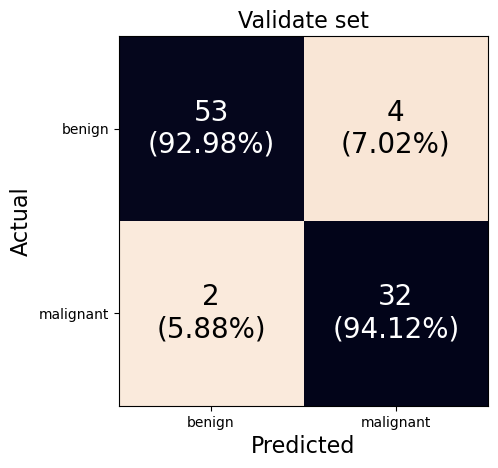

################# test set ##################
Best Threshold=0.427490
FPR: 0.0278
TPR: 0.9048
Confusion Matrix
----------------
[[70  2]
 [ 4 38]] 

----------------
split1
Sensitivity: 90.48%
Specificity: 97.22%
Accuracy: 94.74%
Precision: 95.00%
Sensitivity: 90.48%
Precision: 95.00%
F1: 92.68%


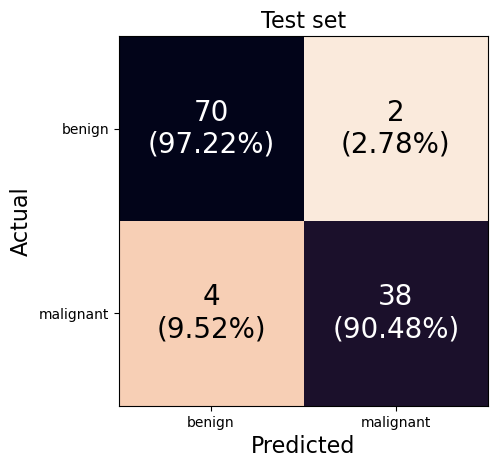

---------------------------------------
AUC validate: 97.16%
AUC test: 98.31%


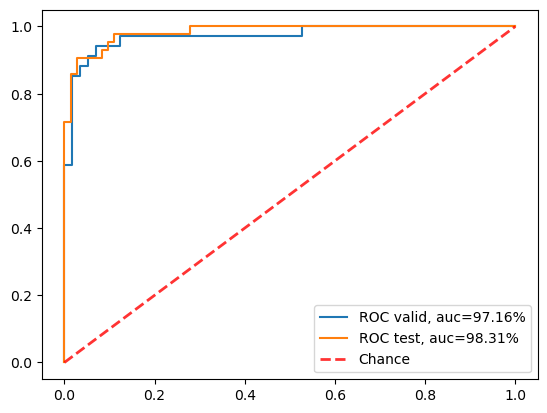

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
38   918192         B         13.17      594.2          0.12480   
44   868223         B         16.67      423.6          0.10510   
46  8710441         B         15.34      300.2          0.10720   
79   868202         M         22.47      506.3          0.09055   
81   862548         M         19.77      642.5          0.09752   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0.1844                 0.05268       2.060   
38         0.10100         0.1976                 0.06457       2.635   
44         0.03592         0.1339                 0.05945       2.508   
46         0.41080         0.2548                 0.09296       2.664   
79         0.04711         0.1585                 0.06065       1.380   
81         0.09388         0.1879        

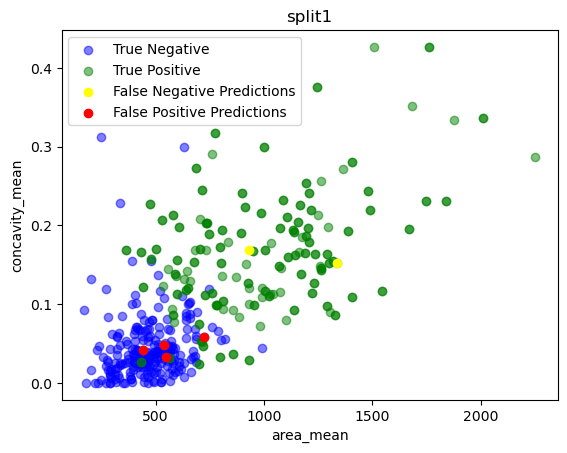

In [86]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

## split2

In [87]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [88]:
# train_param5(split)

../SVM_progress3/model/param5/SVM_model_split2.pkl
############## validate set ################
Best Threshold=0.389451
FPR: 0.0526
TPR: 0.9412
Confusion Matrix
----------------
[[54  3]
 [ 2 32]] 

----------------
split2
Sensitivity: 94.12%
Specificity: 94.74%
Accuracy: 94.51%
Precision: 91.43%
Sensitivity: 94.12%
Precision: 91.43%
F1: 92.75%


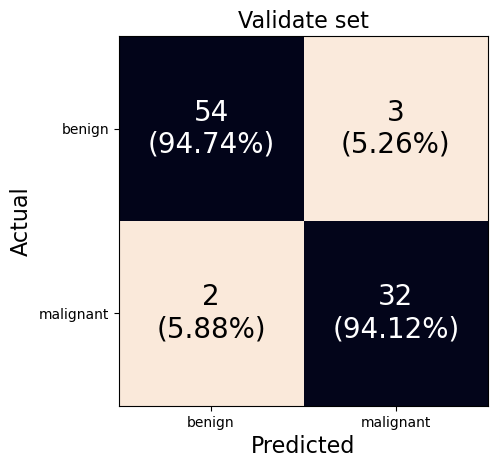

################# test set ##################
Best Threshold=0.333497
FPR: 0.0833
TPR: 0.9048
Confusion Matrix
----------------
[[66  6]
 [ 4 38]] 

----------------
split2
Sensitivity: 90.48%
Specificity: 91.67%
Accuracy: 91.23%
Precision: 86.36%
Sensitivity: 90.48%
Precision: 86.36%
F1: 88.37%


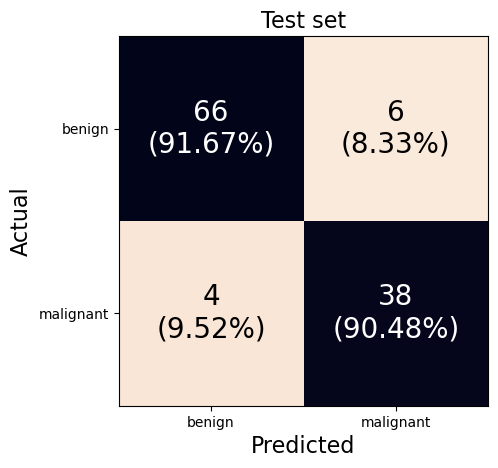

---------------------------------------
AUC validate: 97.27%
AUC test: 97.09%


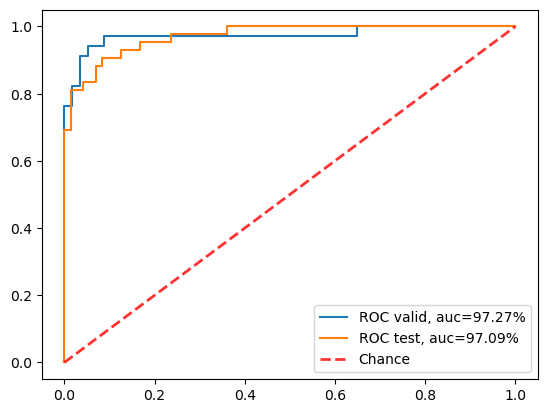

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
11    859471         B         17.33      250.5          0.10660   
12   9112366         B         29.29      415.1          0.09357   
49  88249602         B         21.25      603.4          0.09070   
57    855167         M         21.58      563.0          0.08162   
87  91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.31300         0.2111                 0.08046      1.1940   
12         0.07160         0.1799                 0.06166      2.4260   
49         0.01462         0.1517                 0.05835      1.5030   
57         0.03110         0.1784                 0.05587      0.8265   
87         0.07486         0.1561                 0.05915      1.1980   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    17.67       0.00

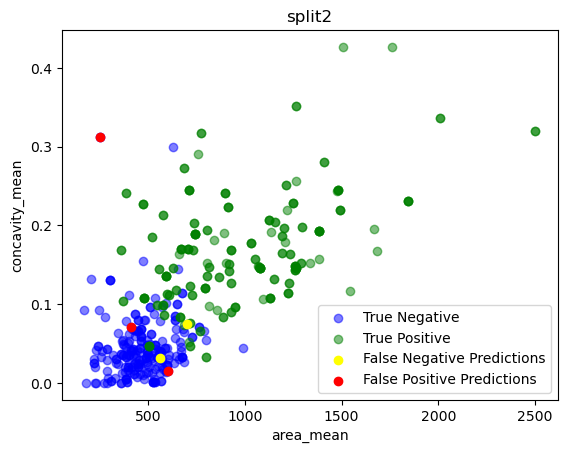

In [89]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

## split3

In [90]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [91]:
# train_param5(split)

../SVM_progress3/model/param5/SVM_model_split3.pkl
############## validate set ################
Best Threshold=0.619115
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


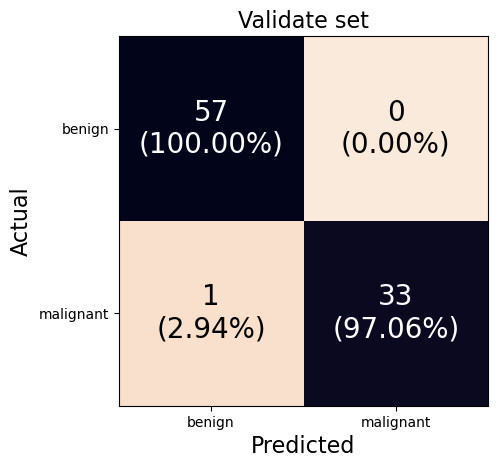

################# test set ##################
Best Threshold=0.146571
FPR: 0.1389
TPR: 1.0000
Confusion Matrix
----------------
[[62 10]
 [ 0 42]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 86.11%
Accuracy: 91.23%
Precision: 80.77%
Sensitivity: 100.00%
Precision: 80.77%
F1: 89.36%


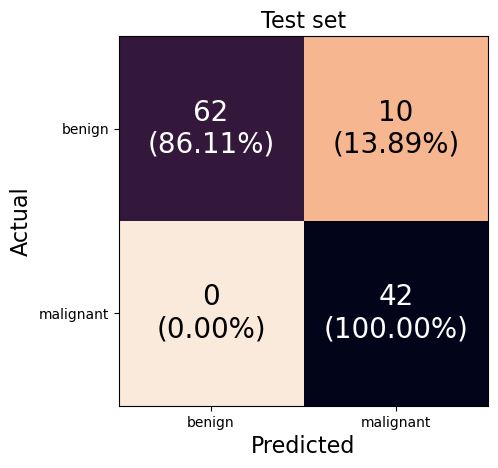

---------------------------------------
AUC validate: 98.45%
AUC test: 98.21%


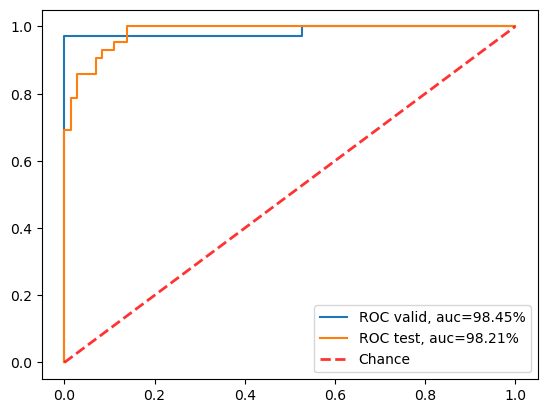

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
87  892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
87         0.02685         0.1619                 0.06287       2.105   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
87    49.11       0.005596       0.01272      0.01575              0.002758   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
87            0.1137           0.0612          0.1978                  0.06915  
[87]


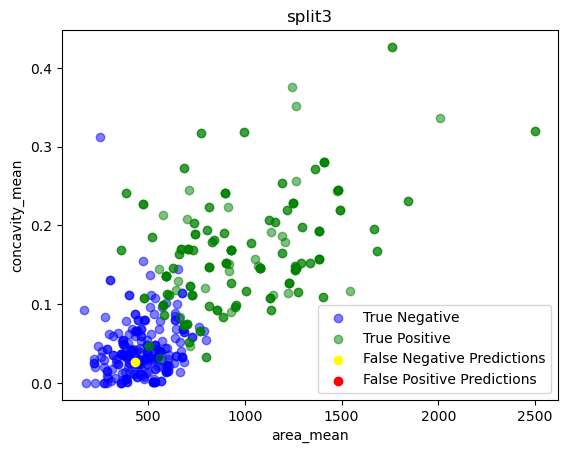

In [92]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

## split4

In [93]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [94]:
# train_param5(split)

../SVM_progress3/model/param5/SVM_model_split4.pkl
############## validate set ################
Best Threshold=0.564827
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


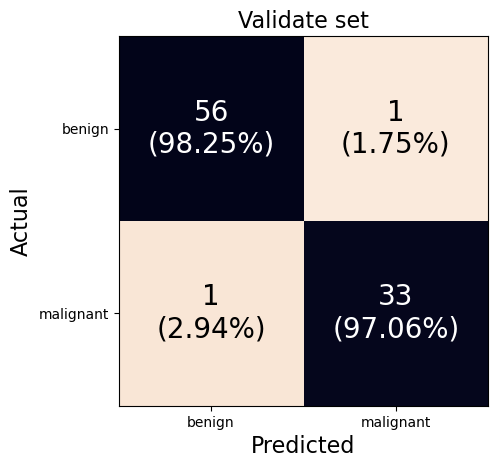

################# test set ##################
Best Threshold=0.417237
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


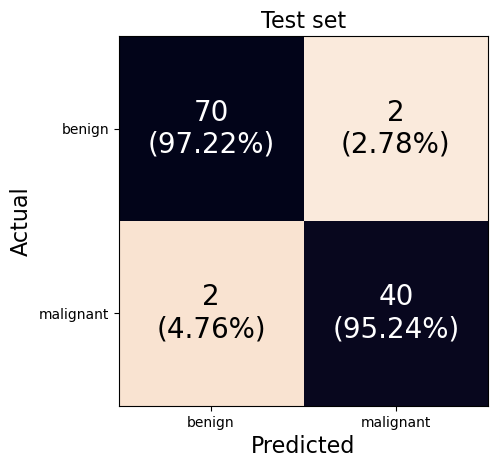

---------------------------------------
AUC validate: 98.66%
AUC test: 98.12%


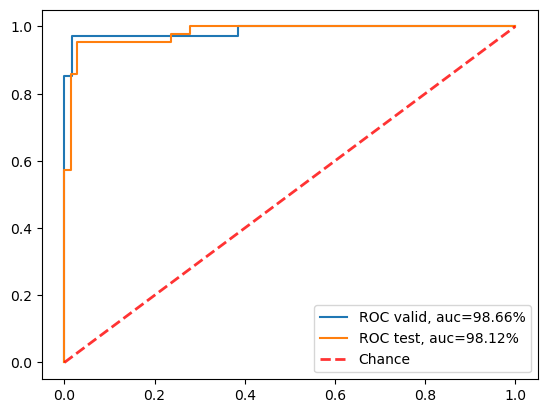

################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.1872                 0.06341      1.0790   
70         0.07789         0.1662                 0.06566      0.6205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    23.11       0.007138       0.03829      0.02068              0.006111   
70    23.35       0.004717       0.01759      0.01220              0.003130   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1340           0.4040          0.3187                   0.1023  
70            0.1411           0.2779          0.2589                   0.1030  
[37, 70]


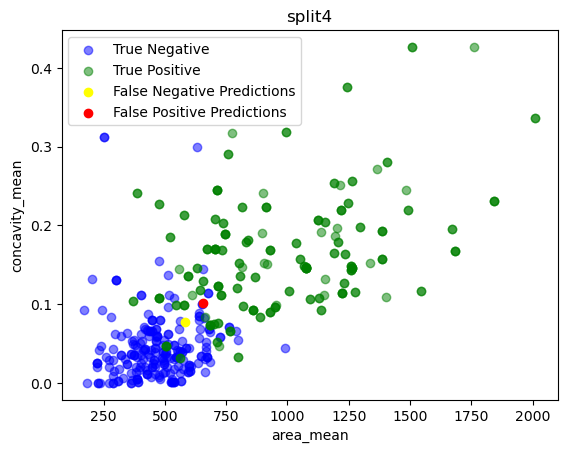

In [95]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

## split5

In [96]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [97]:
# train_param5(split)

../SVM_progress3/model/param5/SVM_model_split5.pkl
############## validate set ################
Best Threshold=0.185770
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


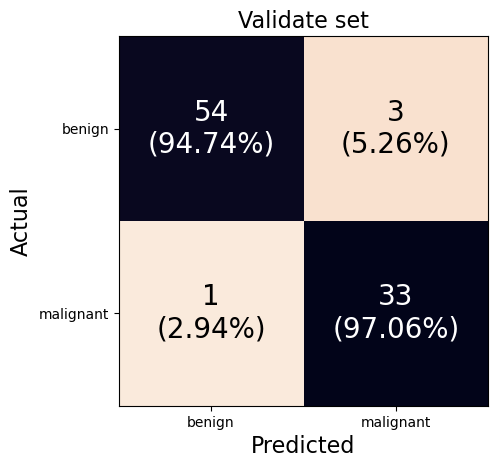

################# test set ##################
Best Threshold=0.287857
FPR: 0.0833
TPR: 0.9524
Confusion Matrix
----------------
[[66  6]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 91.67%
Accuracy: 92.98%
Precision: 86.96%
Sensitivity: 95.24%
Precision: 86.96%
F1: 90.91%


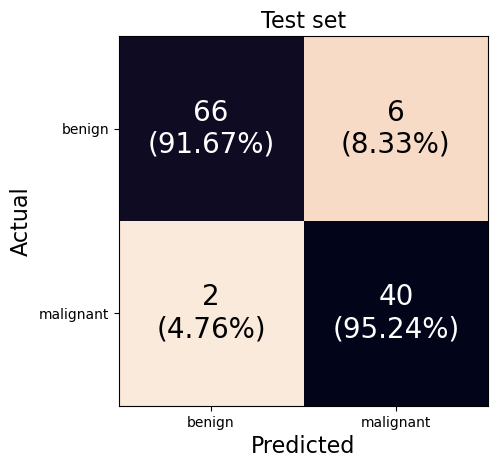

---------------------------------------
AUC validate: 98.25%
AUC test: 97.65%


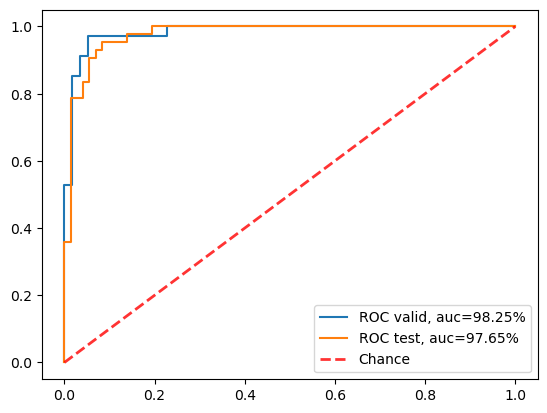

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
20   905502         B         17.57      399.8          0.08858   
22     8915         B         19.10      687.3          0.08992   
43  9113455         B         20.74      536.9          0.08675   
87   905680         M         29.81      719.5          0.08320   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.02783         0.1601                 0.05913      1.5550   
22         0.05940         0.1879                 0.05852      0.9480   
43         0.10850         0.1562                 0.06020      0.7884   
87         0.04686         0.1852                 0.05294      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
20    13.66       0.005391       0.01163      0.01341              0.001659   
22    24.87       0.005332       0.01536      0.01522              0.002815   
43    27.4

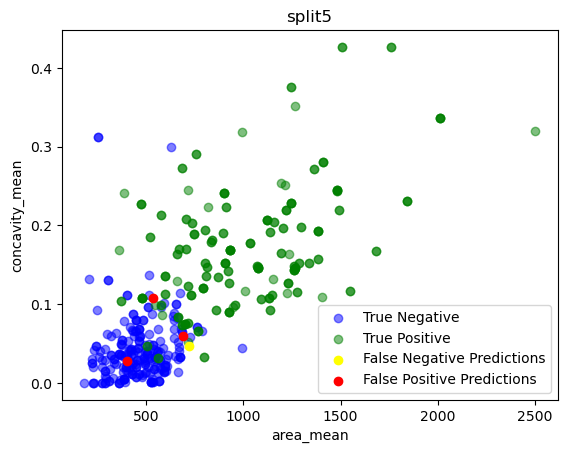

In [98]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# Overall

## param1

param1
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%

split2
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 96.47 ± 1.32%
specificity: 96.84 ± 2.60%
accuracy: 96.70 ± 2.06%
precision: 94.90 ± 4.11%
f1_score: 95.66 ± 2.64%


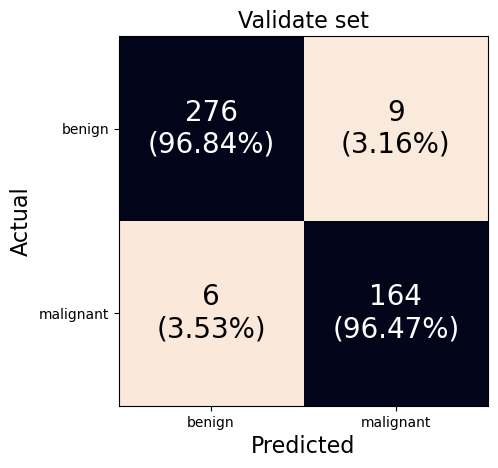

AUC1: 9847.27 ± 73.93%


In [99]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC1",param1_split1_AUC_val*100, param1_split2_AUC_val*100, param1_split3_AUC_val*100, param1_split4_AUC_val*100, param1_split5_AUC_val*100)

## param2

param2
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 1.35%
precision: 97.07 ± 2.02%
f1_score: 97.06 ± 1.80%


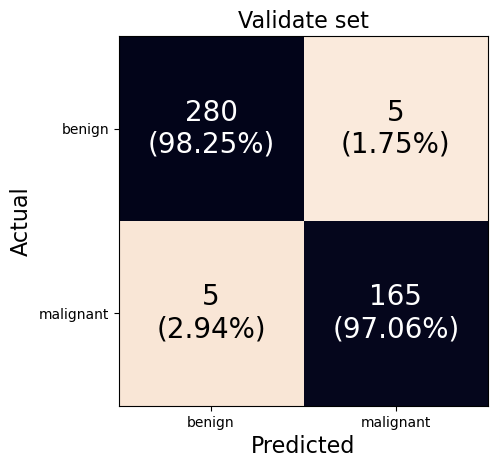

AUC1: 9946.34 ± 55.29%


In [100]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC1",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)

## param3

param3
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%

split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

overall
sensitivity: 95.88 ± 2.63%
specificity: 97.89 ± 1.92%
accuracy: 97.14 ± 0.98%
precision: 96.57 ± 3.02%
f1_score: 96.17 ± 1.28%


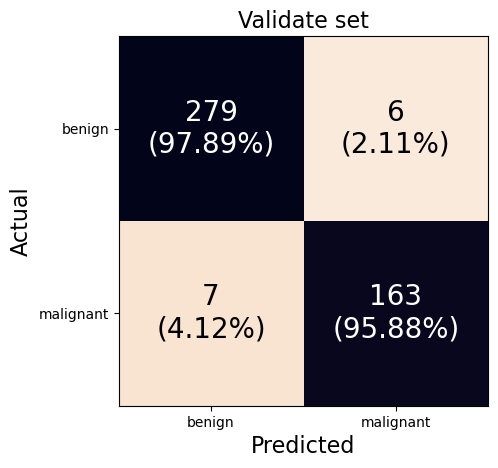

AUC1: 9933.95 ± 58.99%


In [101]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param3_split1_AUC_val*100, param3_split2_AUC_val*100, param3_split3_AUC_val*100, param3_split4_AUC_val*100, param3_split5_AUC_val*100)

## param4

param4
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%

split2
Sensitivity: 94.12%
Specificity: 94.74%
Accuracy: 94.51%
Precision: 91.43%
Sensitivity: 94.12%
Precision: 91.43%
F1: 92.75%

split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

overall
sensitivity: 95.88 ± 1.61%
specificity: 96.14 ± 2.88%
accuracy: 96.04 ± 2.28%
precision: 93.81 ± 4.56%
f1_score: 94.81 ± 2.94%


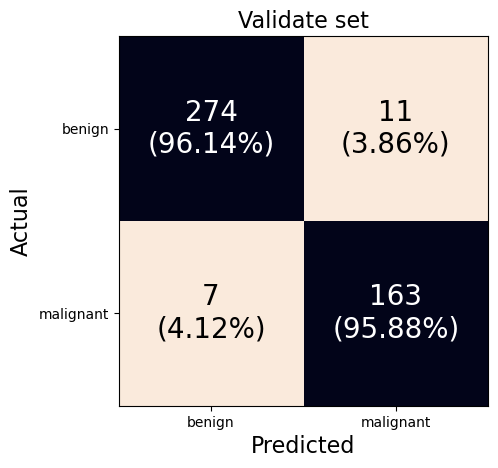

AUC1: 9795.67 ± 69.48%


In [102]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)
Mean_SD("AUC1",param4_split1_AUC_val*100, param4_split2_AUC_val*100, param4_split3_AUC_val*100, param4_split4_AUC_val*100, param4_split5_AUC_val*100)

## param5

param5
split1
Sensitivity: 94.12%
Specificity: 92.98%
Accuracy: 93.41%
Precision: 88.89%
Sensitivity: 94.12%
Precision: 88.89%
F1: 91.43%

split2
Sensitivity: 94.12%
Specificity: 94.74%
Accuracy: 94.51%
Precision: 91.43%
Sensitivity: 94.12%
Precision: 91.43%
F1: 92.75%

split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

overall
sensitivity: 95.88 ± 1.61%
specificity: 96.14 ± 2.88%
accuracy: 96.04 ± 2.28%
precision: 93.81 ± 4.56%
f1_score: 94.81 ± 2.94%


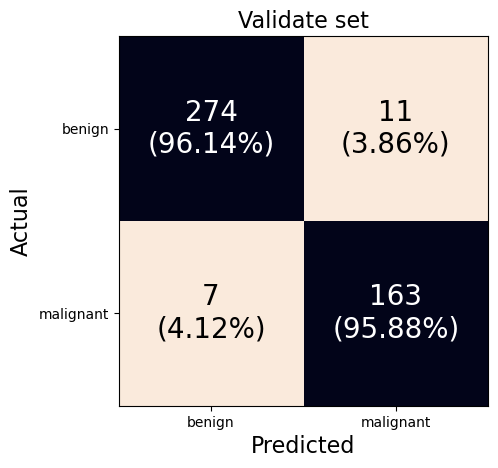

AUC1: 9795.67 ± 69.48%


In [103]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param5_split1_AUC_val*100, param5_split2_AUC_val*100, param5_split3_AUC_val*100, param5_split4_AUC_val*100, param5_split5_AUC_val*100)

# Test best param

In [104]:
train_path = "../kitt/DATA_progress3_new/train.csv"
test_path = "../kitt/DATA_progress3_new/test.csv"

In [105]:
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the test se
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(455, 18)
(455, 16)
['B' 'M']
(114, 18)
(114, 16)
['B' 'M']


In [106]:
model = SGDClassifier(loss='modified_huber', penalty='l2', learning_rate='constant', eta0=0.01, max_iter=5000, alpha=0.01)
model.fit(x_train, y_train)# Save the trained model to disk
joblib.dump(model, "../SGD/models/sgd_model_all.pkl")

['../SGD/models/sgd_model_all.pkl']

../SGD/models/sgd_model_all.pkl
################# test set ##################
Best Threshold=0.454518
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


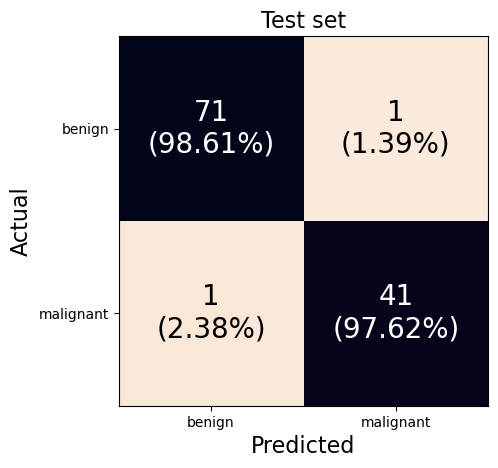

---------------------------------------
AUC test: 99.57%


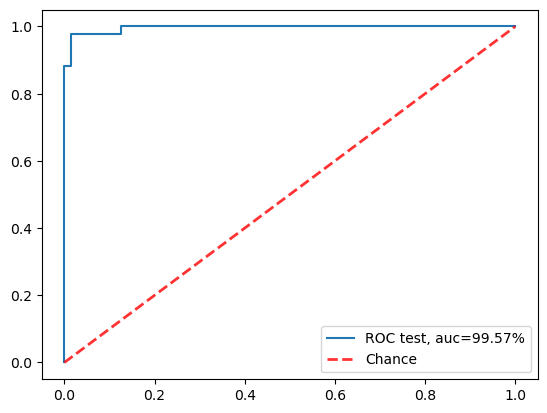

In [107]:
model_path = "../SGD/models/sgd_model_all.pkl"
print(model_path)
loaded_model = joblib.load(model_path)

# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
print(split)
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test,which="Test set")

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()